I submitted this notebook for the in-house competition of the course "Data Mining Models and Algorithms" of the training "Mathematical Expert in Data Analysis and Machine Learning". I finished second based on the evaluation metric. The only rule was that we had to use an SVM algorithm for the prediction.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.pandas.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew, norm
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, ShuffleSplit, KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
RANDOM_STATE = 1
import optuna
from sklearn.inspection import permutation_importance

# EDA

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.drop('Death', axis=1, inplace=True)

In [4]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)

<AxesSubplot:>

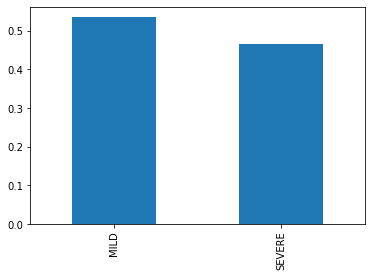

In [16]:
train_df['Prognosis'].value_counts(normalize=True).plot.bar()

More or less balanced dataset, somewhat more mild observations.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589 entries, 0 to 1588
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Row_number             1589 non-null   float64
 1   Hospital               1589 non-null   object 
 2   Age                    1588 non-null   float64
 3   Sex                    1589 non-null   int64  
 4   PositivityAtAdmission  1550 non-null   float64
 5   Temp_C                 1415 non-null   float64
 6   DaysFever              1179 non-null   float64
 7   Cough                  1582 non-null   float64
 8   DifficultyInBreathing  1583 non-null   float64
 9   WBC                    1563 non-null   float64
 10  RBC                    1537 non-null   float64
 11  CRP                    1529 non-null   float64
 12  Fibrinogen             279 non-null    float64
 13  Glucose                1382 non-null   float64
 14  PCT                    913 non-null    float64
 15  LDH 

In [5]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object']
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'object']
discrete_features = [feature for feature in numerical_features if len(df[feature].unique()) <= 25]
continuous_features = [feature for feature in numerical_features if len(df[feature].unique()) > 25]
print(len(continuous_features) + len(discrete_features) == len(numerical_features))
print(len(numerical_features) + len(categorical_features) == len(df.columns))

True
True


In [ ]:
print('categorical:',len(categorical_features))
print('discrete:',len(discrete_features))
print('continuous:',len(continuous_features))

categorical: 2
discrete: 19
continuous: 18


## Continuous features

In [56]:
def diagnostic_plots(df, variable):
    # distplot with theoretical norm
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], fit=norm, bins=30, color='b')
    plt.title(variable)
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.title(variable)
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title(variable)
    plt.show()

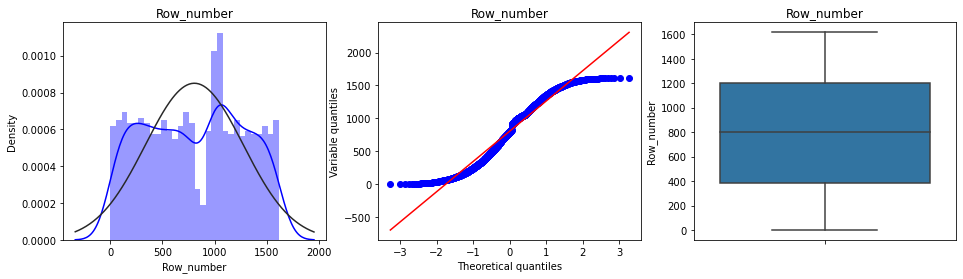

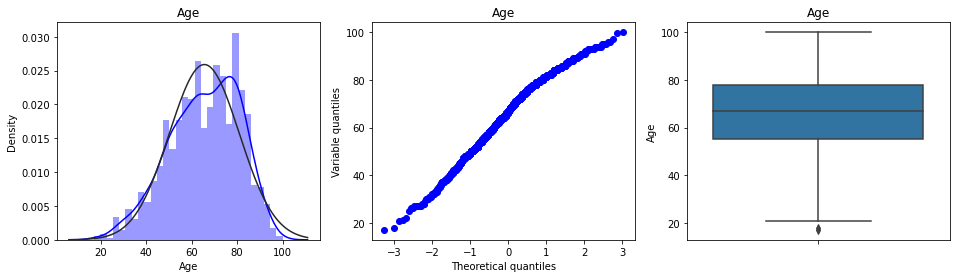

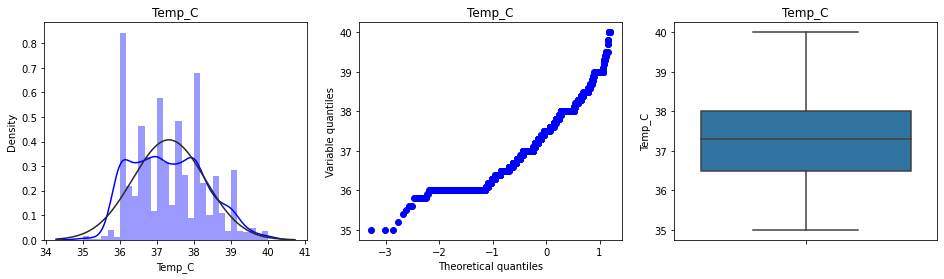

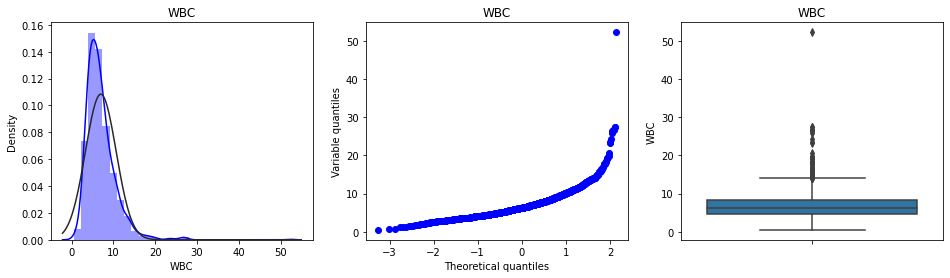

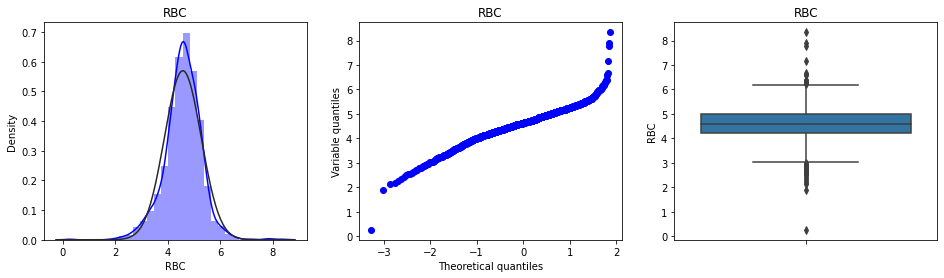

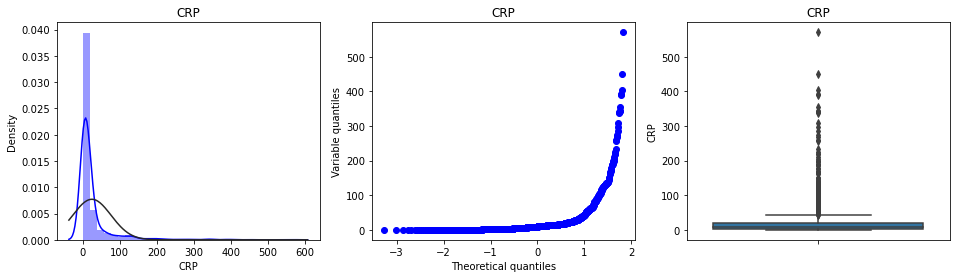

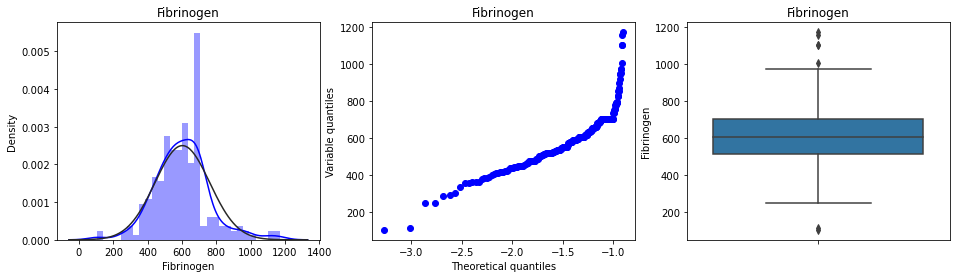

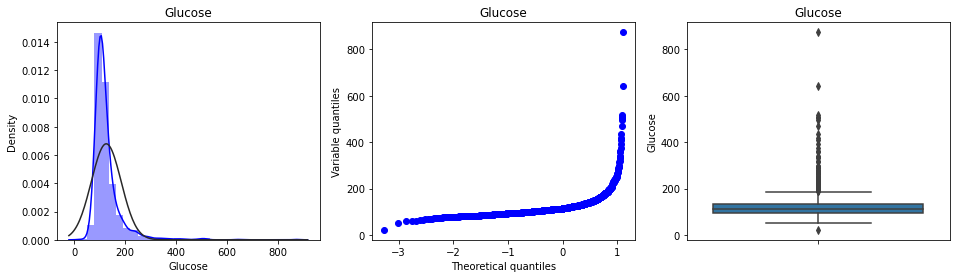

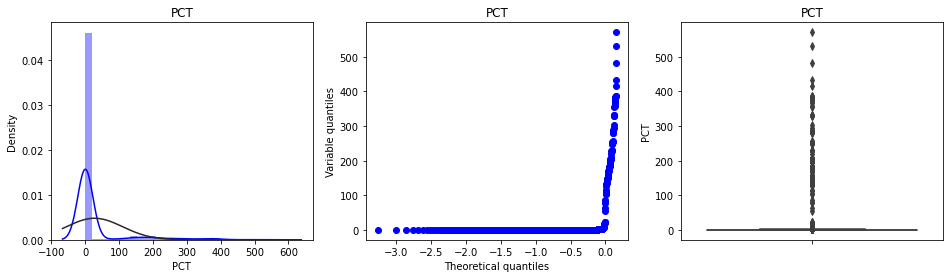

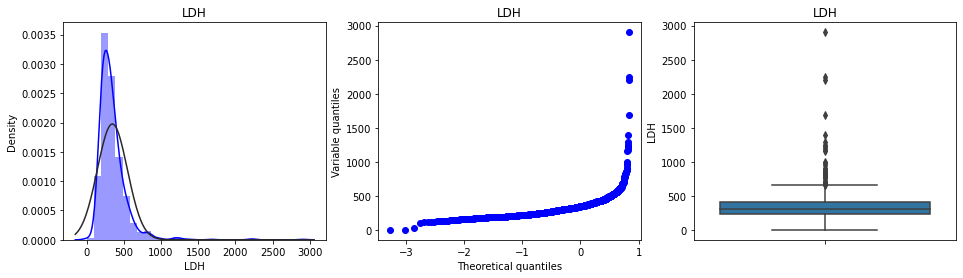

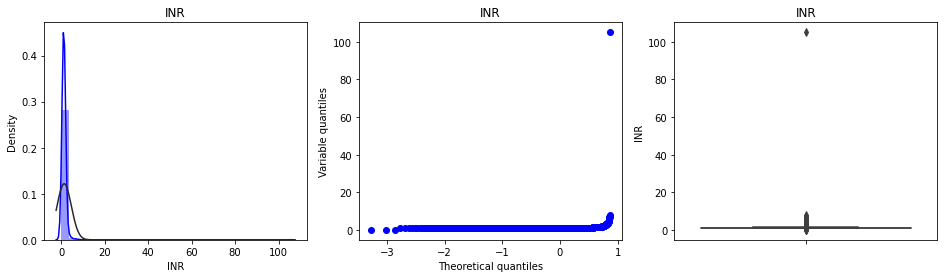

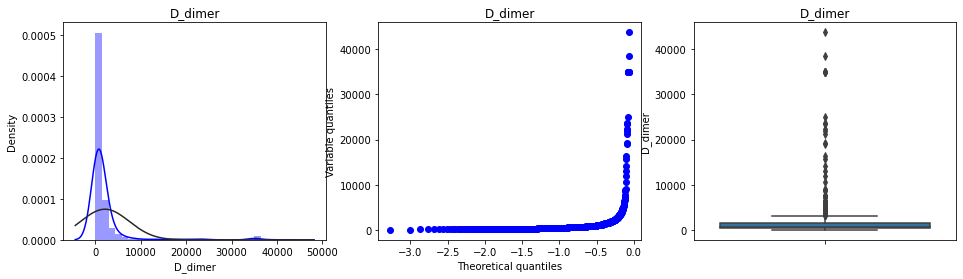

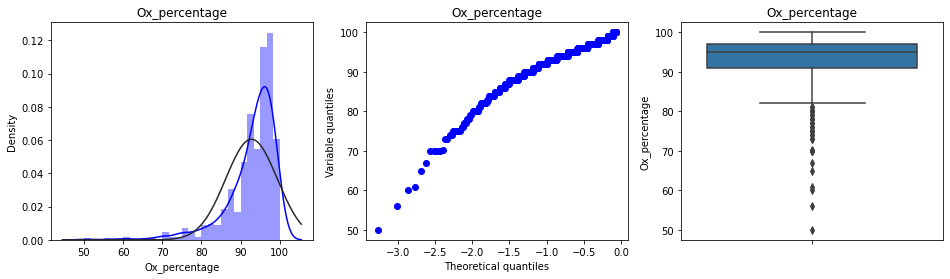

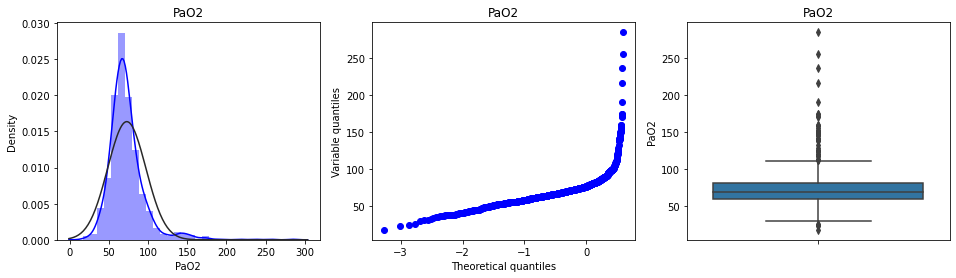

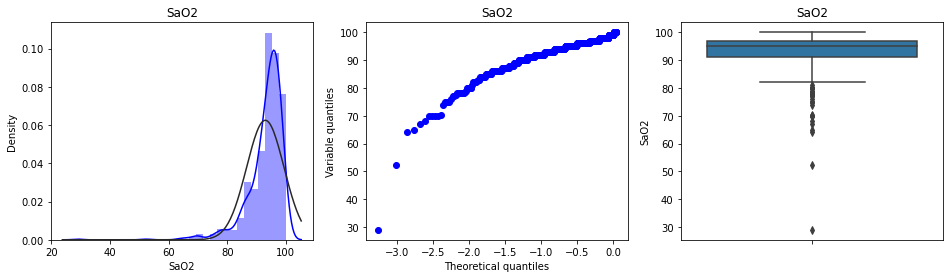

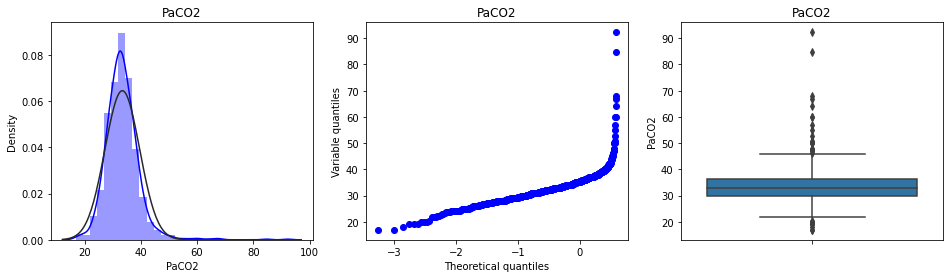

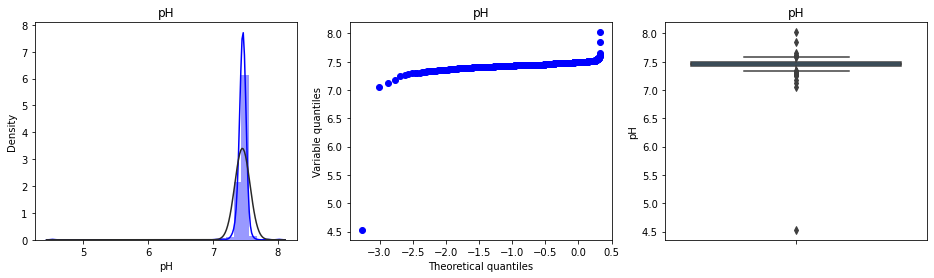

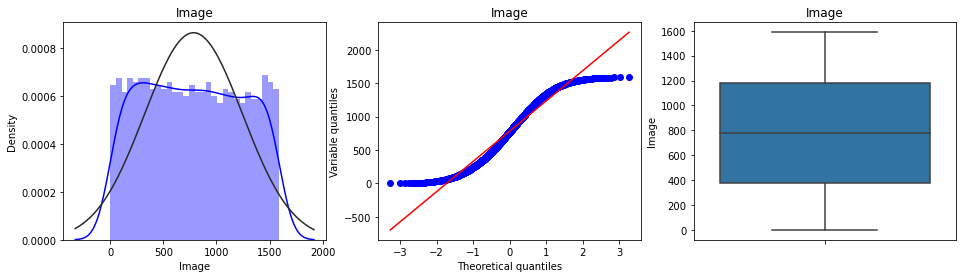

In [ ]:
for feature in continuous_features:
    diagnostic_plots(train_df, feature)

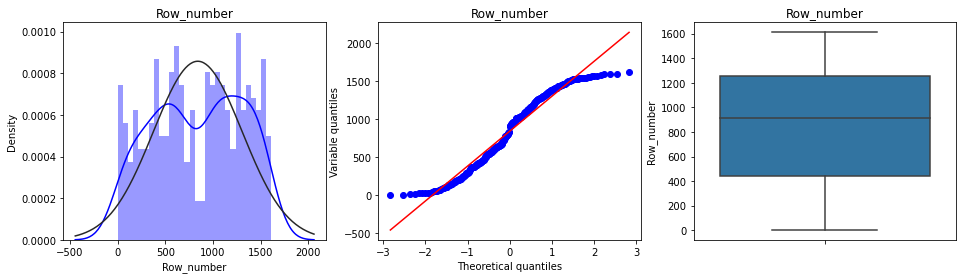

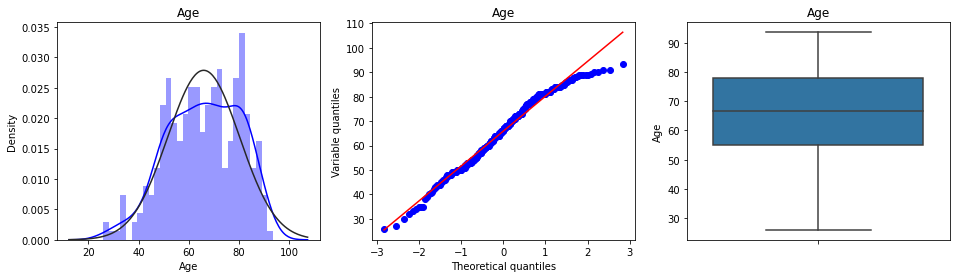

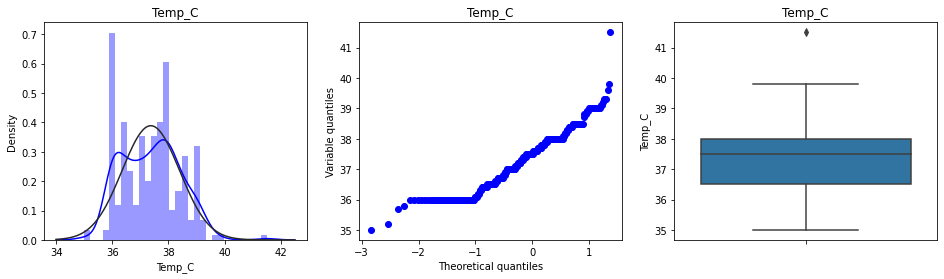

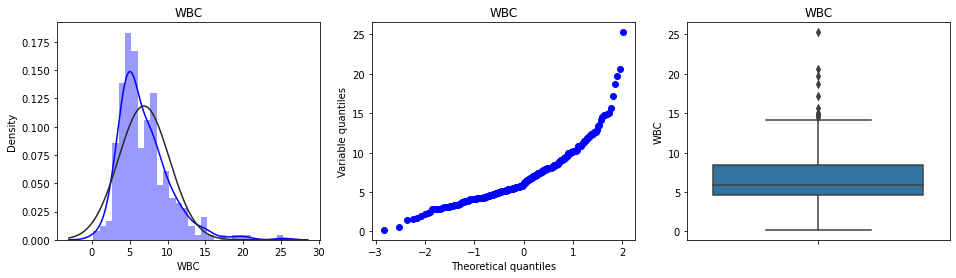

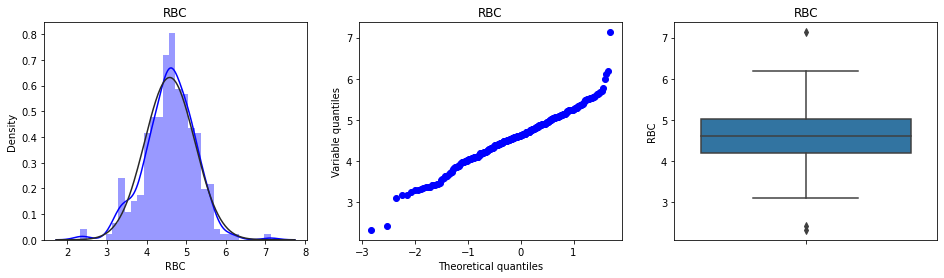

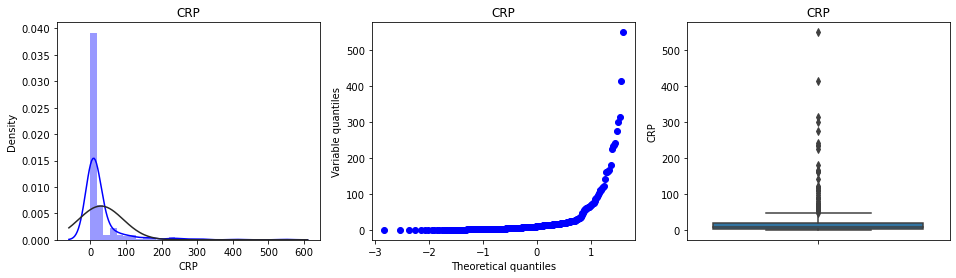

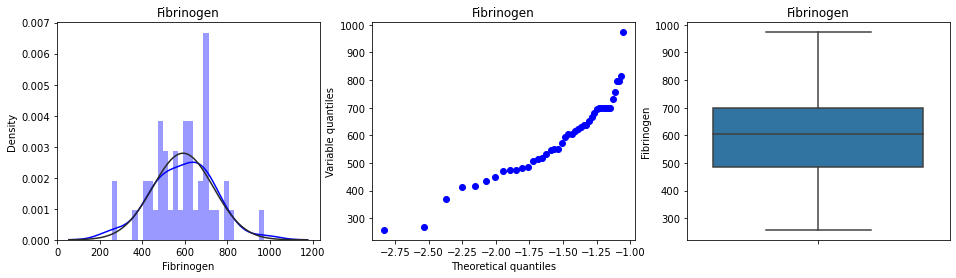

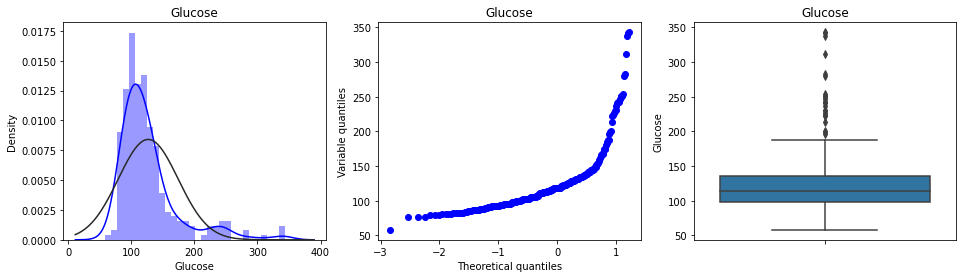

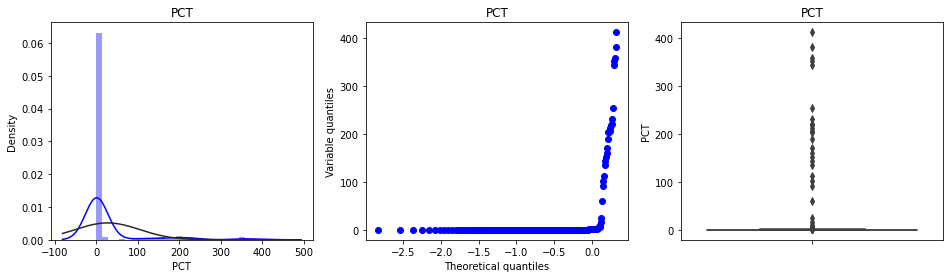

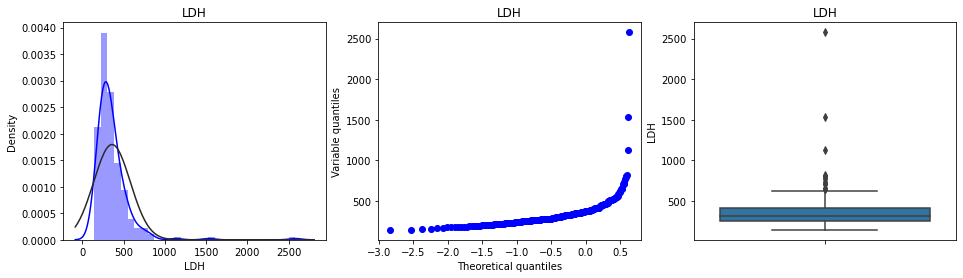

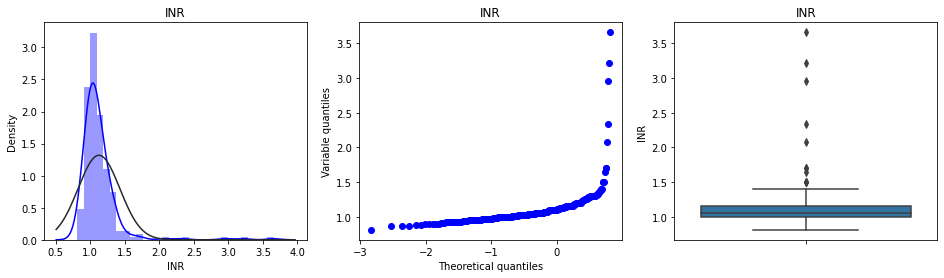

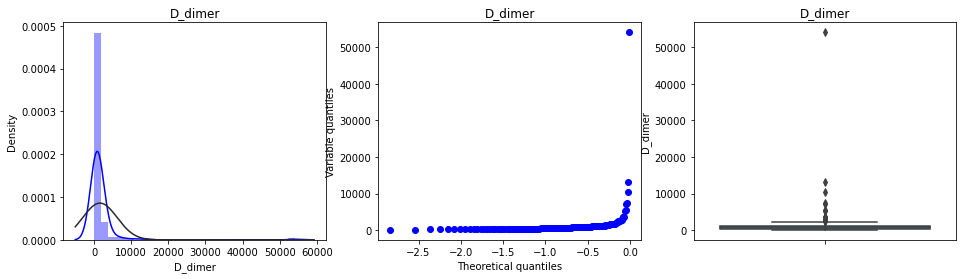

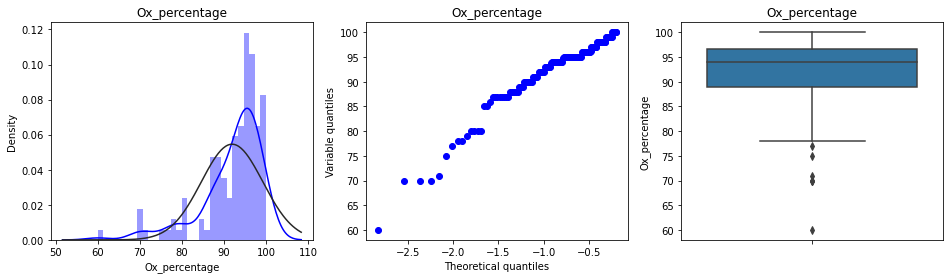

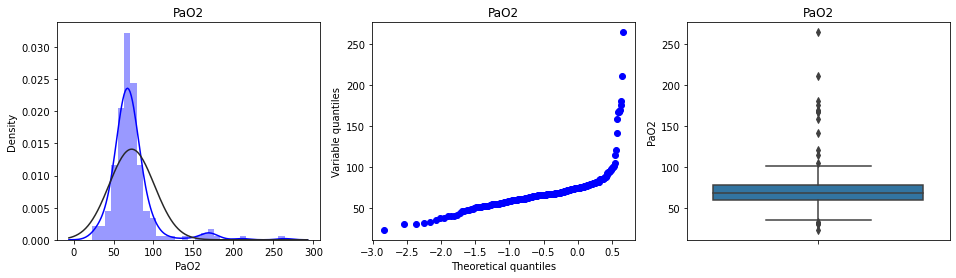

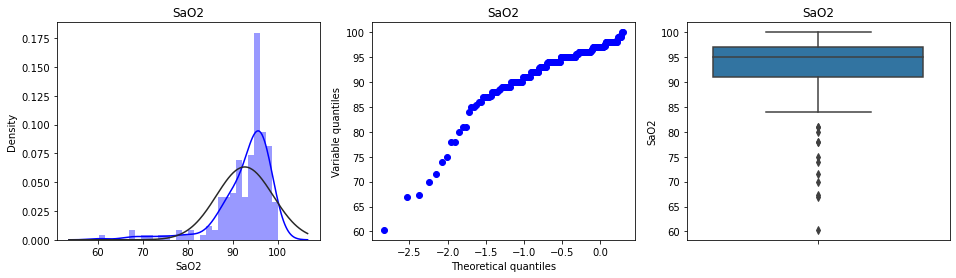

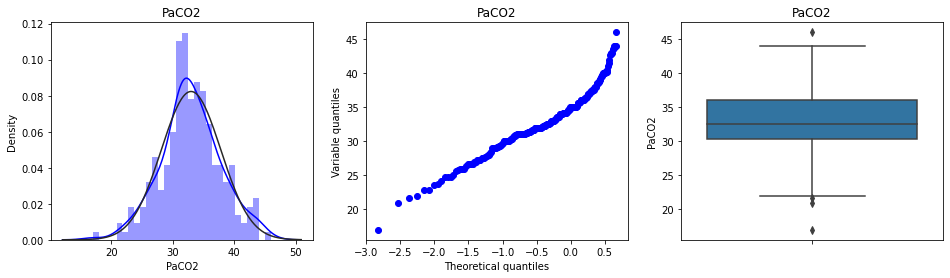

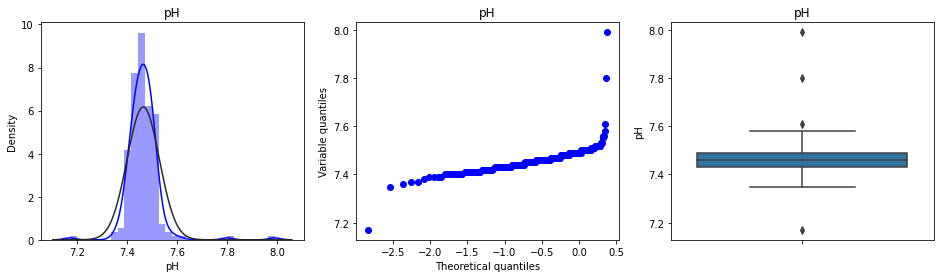

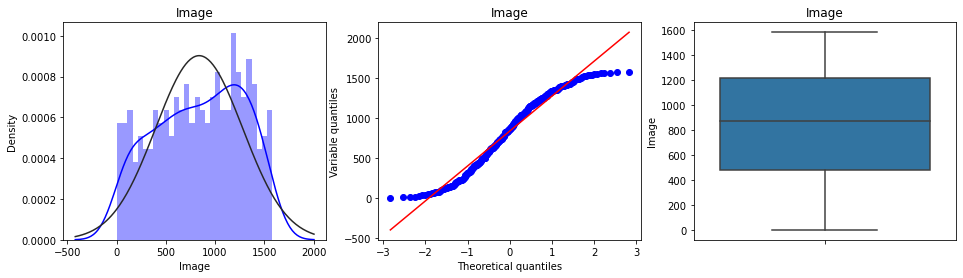

In [ ]:
for feature in continuous_features:
    diagnostic_plots(test_df, feature)

Some observations:
- in general quite similar distributions
- the distributions are quite skewed, but for SVM normalization is necessary
- there are some outliers in the train to drop (WBC, Age)
- extreme values in CRP and Temp_C both in train and test

### Outlier detection

In [ ]:
train_df[train_df['Glucose']>500].sort_values('Glucose', ascending=False)

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
870,964.0,F,31.000000,1,1.0,37.0,2.0,0.0,0.0,9.30,5.38,0.96,NaN,874.0,0.02,224.0,0.95,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,233,MILD
910,1181.0,F,60.000000,0,1.0,36.9,2.0,0.0,1.0,14.90,4.72,16.06,NaN,641.0,0.25,697.0,1.01,35000.0,NaN,146.0,NaN,32.8,7.43,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,893,SEVERE
815,641.0,F,88.000000,1,1.0,36.2,NaN,0.0,1.0,14.10,4.57,12.91,NaN,519.0,NaN,306.0,1.11,NaN,95.0,77.8,95.0,16.9,7.37,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1396,SEVERE
985,1472.0,F,83.000000,1,1.0,36.6,NaN,0.0,0.0,5.72,4.02,4.06,NaN,510.0,0.21,400.0,3.90,449.0,NaN,65.9,97.0,26.4,7.42,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,727,MILD
224,1054.0,C,82.162902,1,1.0,36.0,NaN,0.0,1.0,13.78,5.89,12.30,NaN,505.0,415.00,361.0,1.05,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,457,SEVERE


My intuition is that these observations can be 'risky' outliers. They are both very extreme values, but in different classes in the sense of the response variable. They can effect the hinge loss (missclassification loss). Maybe I should consider to cut all the values that are greater than 500. Also quite a few missing values, so maybe a good idea to remove them.

In [ ]:
train_df[train_df['WBC']>40]

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,...,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
443,1083.0,C,76.027379,0,1.0,37.3,NaN,0.0,0.0,52.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488,SEVERE


443 is an outlier, has to drop it later.

In [ ]:
train_df[train_df['Age']<20]

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,...,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
721,332.0,E,18.0,1,1.0,36.2,3.0,0.0,0.0,6.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,539,MILD
1138,1368.0,F,17.0,0,1.0,36.5,3.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,754,SEVERE


721 and 1138 maybe outliers, should consider to drop them later.

Interesting extreme values, but probably should keep these, because all of the extremely high values in Fibrinogen are classified severe:

In [ ]:
train_df[train_df['Fibrinogen']>1150]
# 973 is the max in the test, there are some above 950 in the train besides these extreme

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
195,980.0,F,78.0,0,1.0,35.4,2.0,0.0,1.0,13.0,4.94,32.45,1155.0,157.0,0.81,684.0,1.17,4657.0,94.0,81.2,NaN,30.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,251,SEVERE
540,462.0,F,66.0,0,1.0,36.8,2.0,1.0,1.0,26.5,4.83,38.23,1171.0,107.0,0.41,800.0,1.18,NaN,76.0,38.3,NaN,37.6,7.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1244,SEVERE


In [ ]:
train_df[['INR']].sort_values('INR', ascending=False).head(10)

,INR
869,105.00
42,8.00
574,7.00
244,6.96
670,6.44
59,5.92
752,4.89
30,4.81
233,4.77
66,4.76


869 is an outlier. 42 and 574 should be considered (comparing to the test values)

In [ ]:
test_df[['INR']].sort_values('INR', ascending=False).head(10)

,INR
292,3.66
222,3.22
47,2.95
282,2.33
275,2.08
184,1.70
174,1.70
166,1.64
142,1.50
177,1.50


In [ ]:
train_df[train_df['SaO2']<30]

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
687,154.0,D,41.0,0,1.0,39.1,3.0,1.0,0.0,10.03,4.61,124.3,700.0,NaN,NaN,451.0,1.24,NaN,94.0,53.0,29.0,92.3,7.48,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,99,SEVERE


In [ ]:
test_df['SaO2'].min()

60.3

687 probably is an outlier.

In [ ]:
train_df[train_df['PaCO2']>80]

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
687,154.0,D,41.0,0,1.0,39.1,3.0,1.0,0.0,10.03,4.61,124.3,700.0,NaN,NaN,451.0,1.24,NaN,94.0,53.0,29.0,92.3,7.48,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,99,SEVERE
793,558.0,B,58.0,0,1.0,38.0,4.0,1.0,1.0,13.00,3.48,337.0,534.0,NaN,NaN,449.0,1.60,23410.0,NaN,71.5,92.7,84.7,7.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1270,SEVERE


In [ ]:
test_df['PaCO2'].max()

46.0

Based on the other plots below I'd rather keep these.

In [ ]:
train_df[train_df['pH']<5]

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
923,1467.0,F,67.0,0,1.0,36.9,4.0,1.0,1.0,5.02,4.91,8.6,NaN,152.0,0.27,456.0,1.0,386.0,NaN,57.9,92.0,27.8,4.53,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,964,SEVERE


This extremely low value, but in general the severe cases has lower pH based on the densities below. Maybe have to keep it I don't know... Anyway, very strange.

In [ ]:
test_df['pH'].min()

7.17

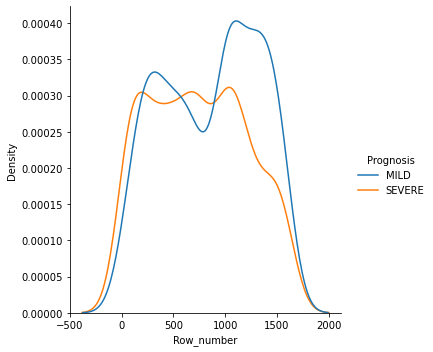

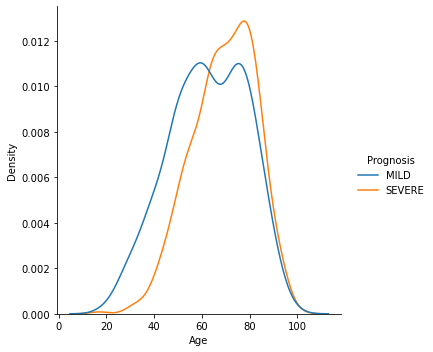

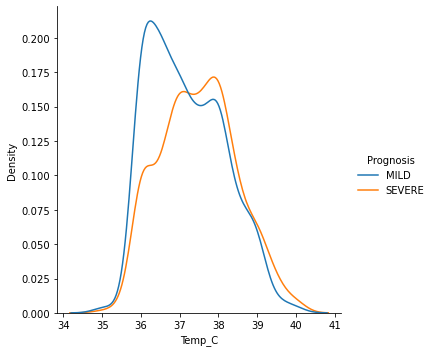

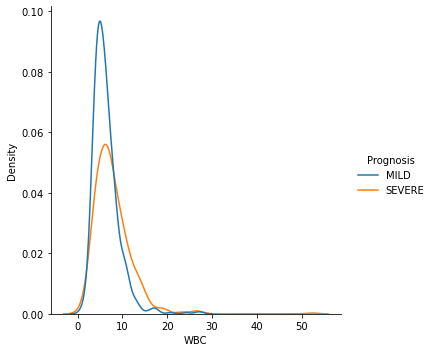

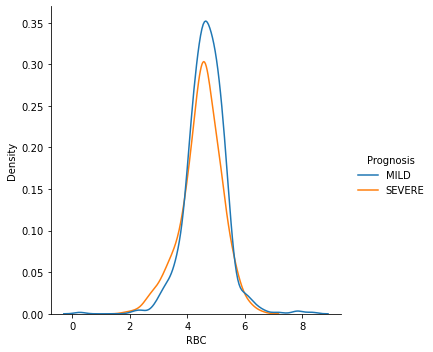

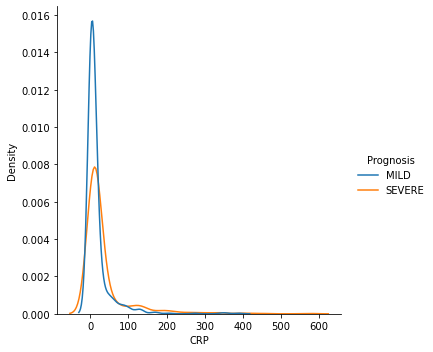

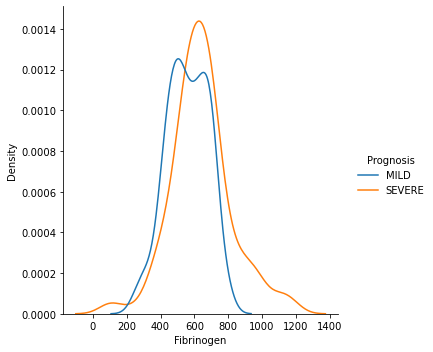

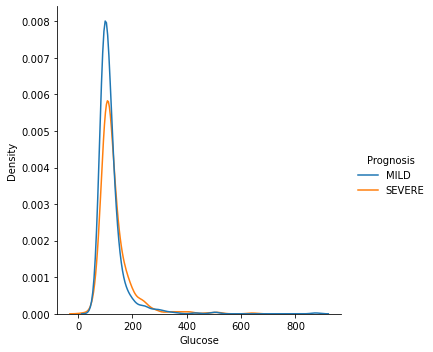

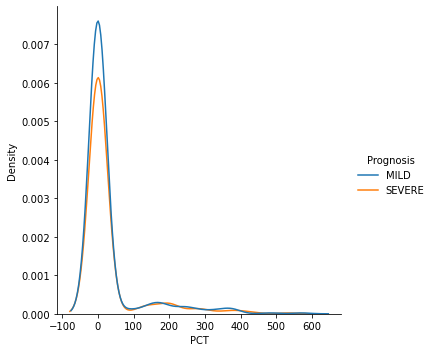

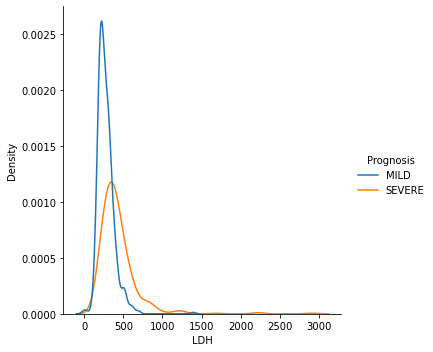

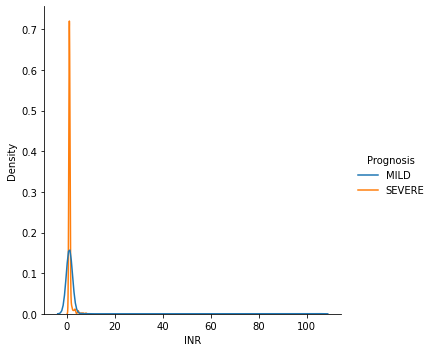

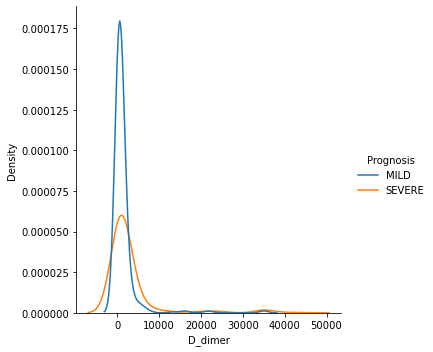

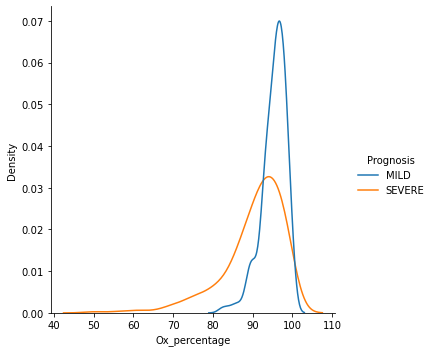

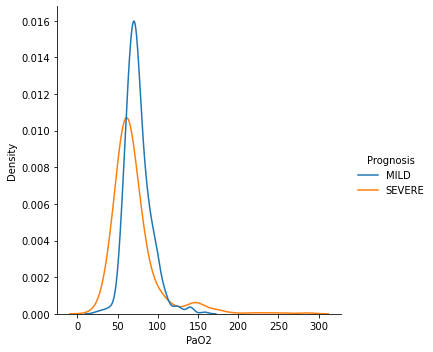

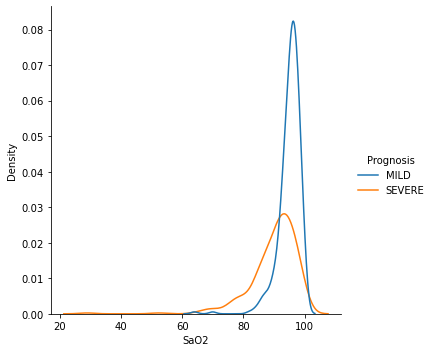

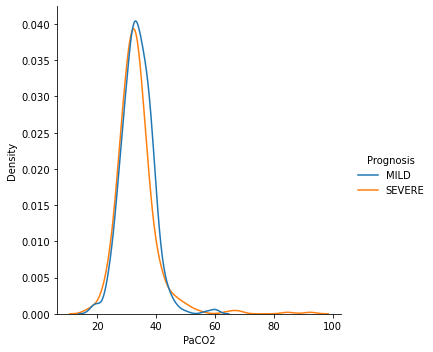

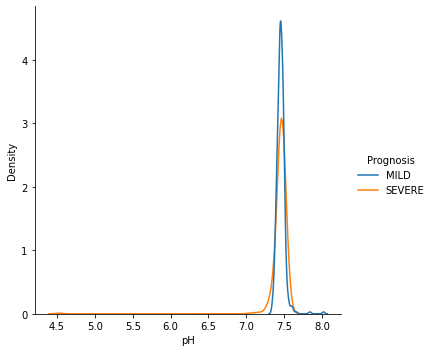

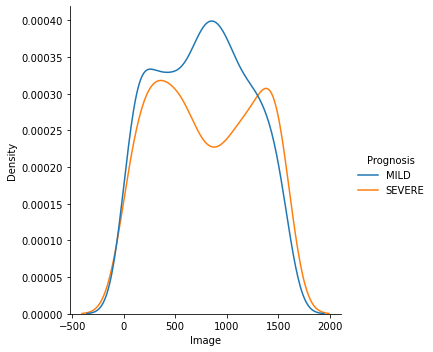

In [ ]:
for feature in continuous_features:
    sns.displot(data=train_df, x=feature, hue='Prognosis', kind='kde')
    plt.show()

Some obvservations:
- The distributions are quite interesting. In some cases the SEVERE cases are heavy tailed (WBC, CRP) and the MILD distribution is peaky (CRP), but the distributions in INR feature are completely the opposite.
- I have to make decisions about the outliers I obtained earlier. SVM is quite sensitive to outliers (if the decision boundary is highly non-linear which I assume is true)
- In Fibrinogen all of the extreme cases seems to be SEVER so maybe it won't cause a big problem to remove the few highly extreme values.
- Maybe it can be interesting to discretize some features, but I will try that later. Specially in the cases where the two densitiy plots are not really overlapping.

## Discrete features

In [ ]:
def compare_plot(train_df, test_df, variable):
    # train df distribution
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_df[variable].value_counts(normalize=True, ascending=True).sort_index(ascending=True).plot(kind='bar')
    plt.axhline(y=0.01, color="red")
    plt.xlabel(variable)
    plt.ylabel('Count')
    # test df distribution
    plt.subplot(1, 2, 2)
    test_df[variable].value_counts(normalize=True, ascending=True).sort_index(ascending=True).plot(kind='bar')
    plt.axhline(y=0.01, color="red")
    plt.xlabel(variable)
    plt.ylabel('Count')
    plt.show()

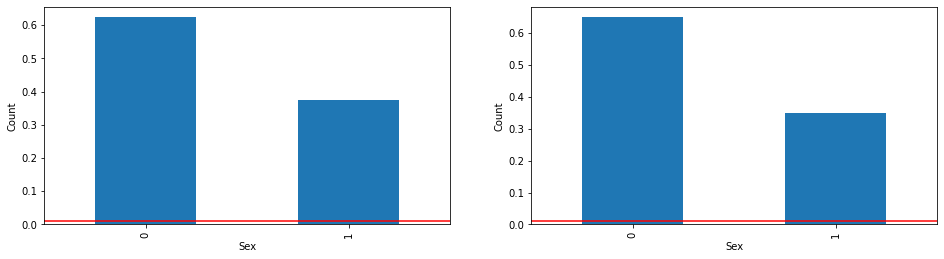

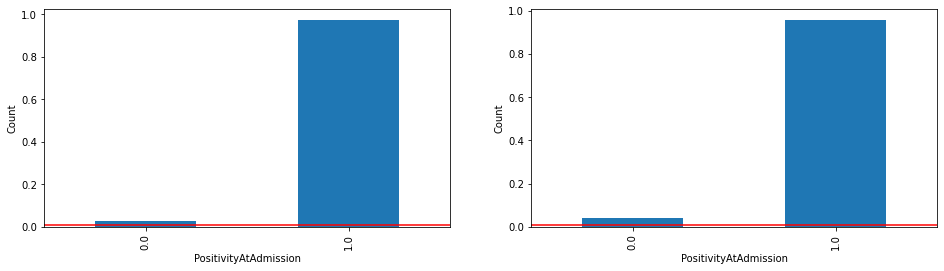

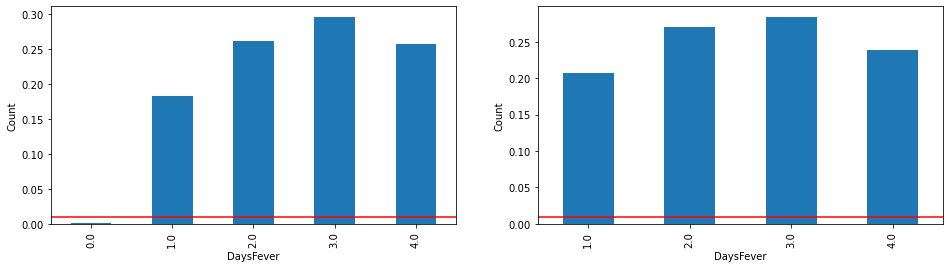

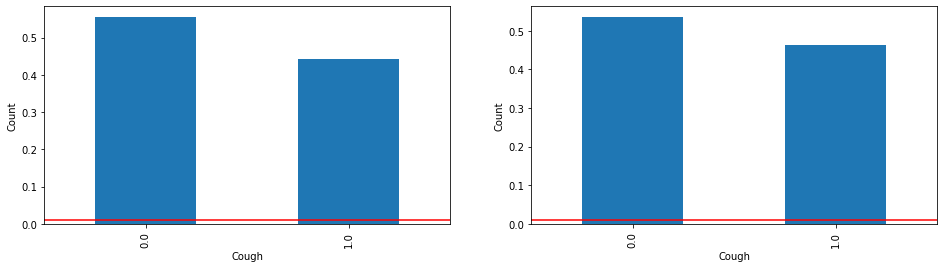

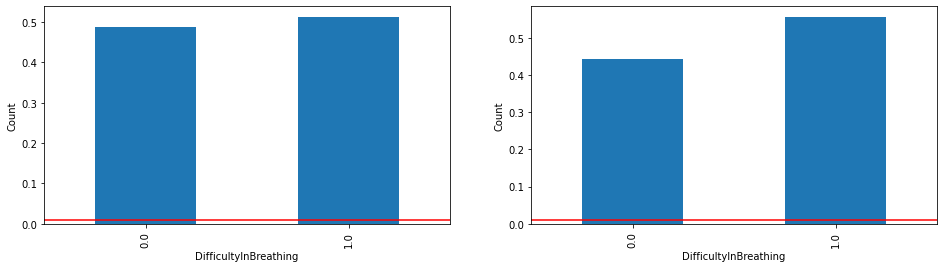

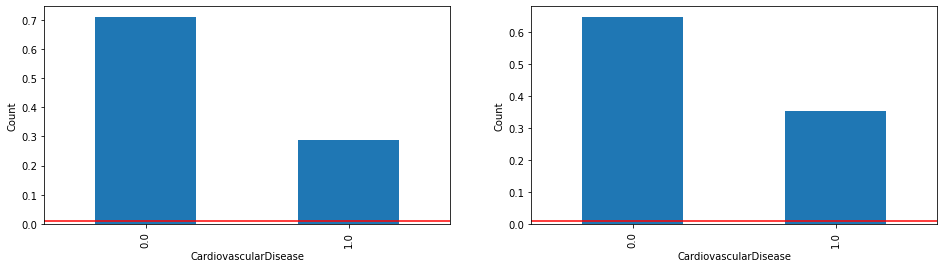

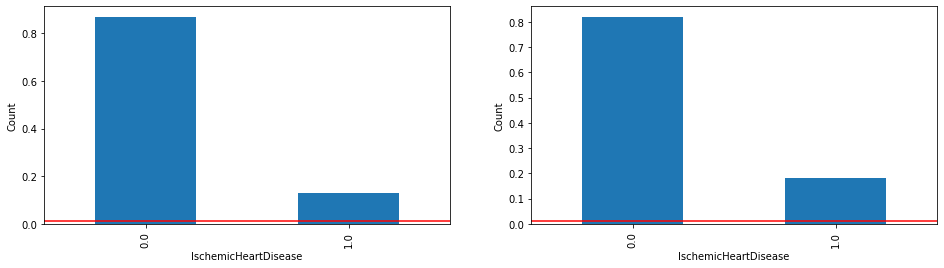

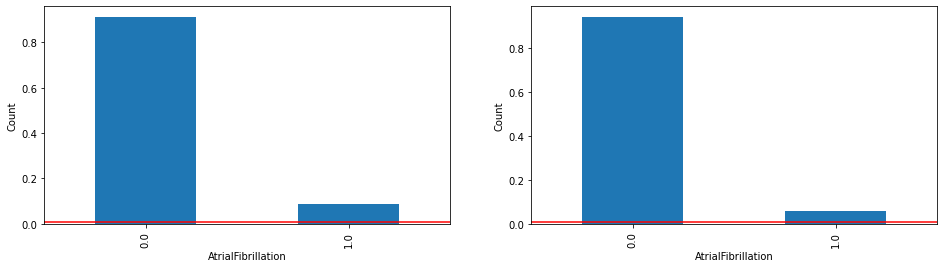

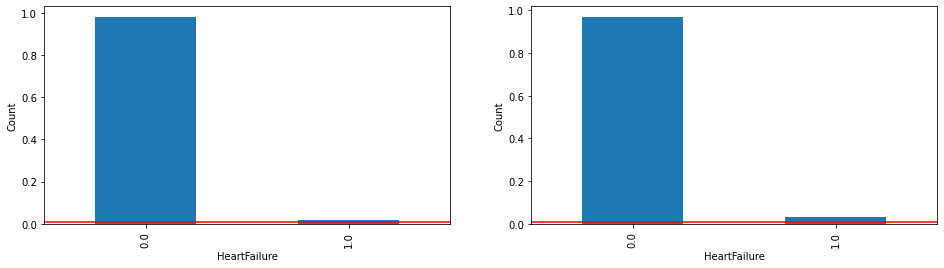

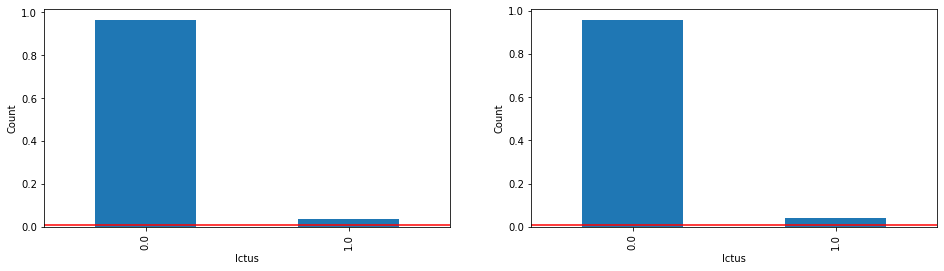

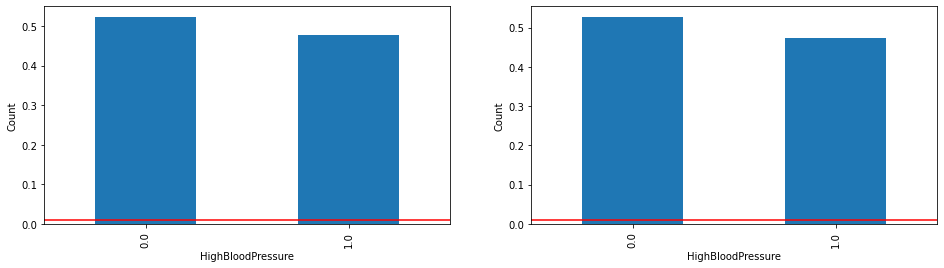

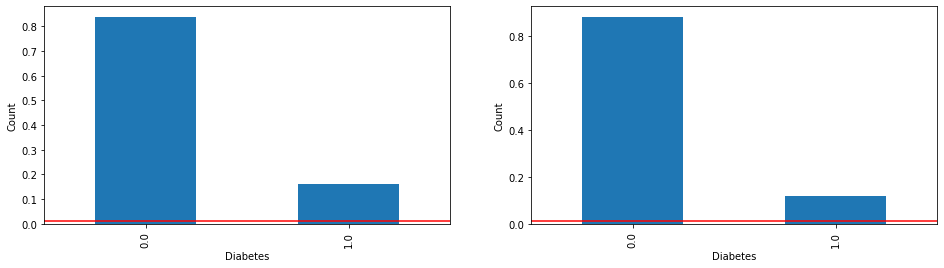

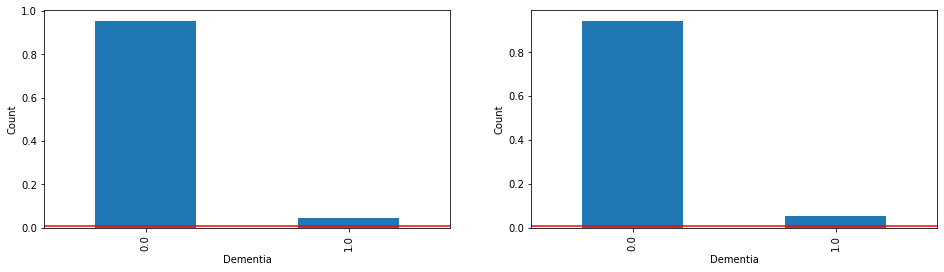

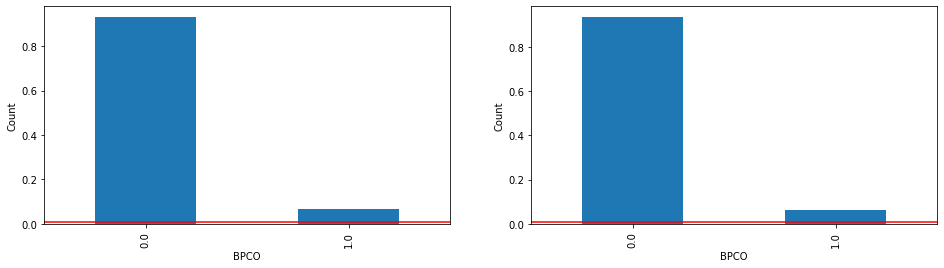

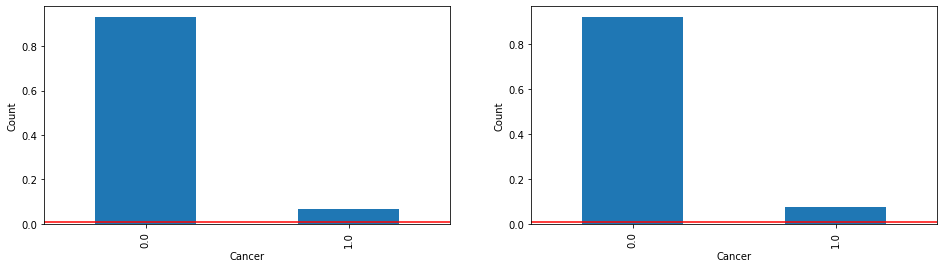

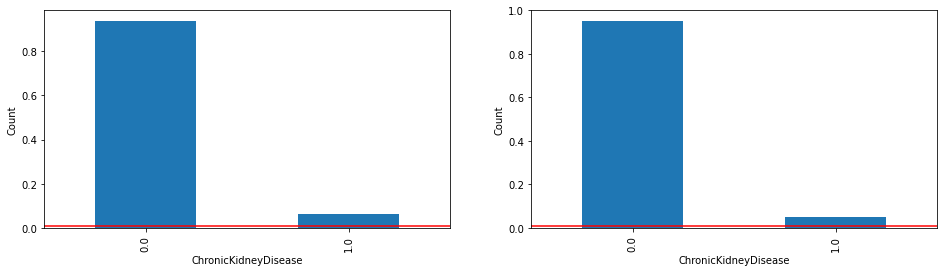

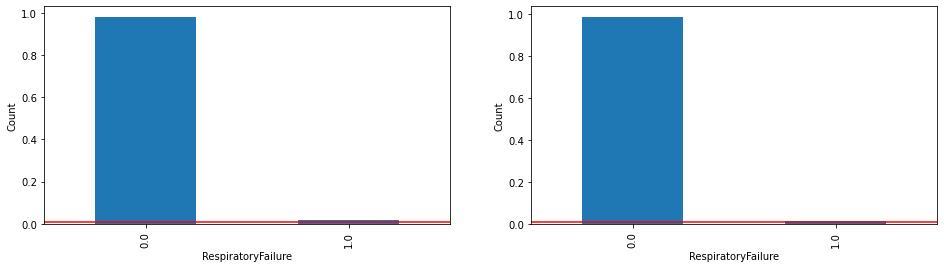

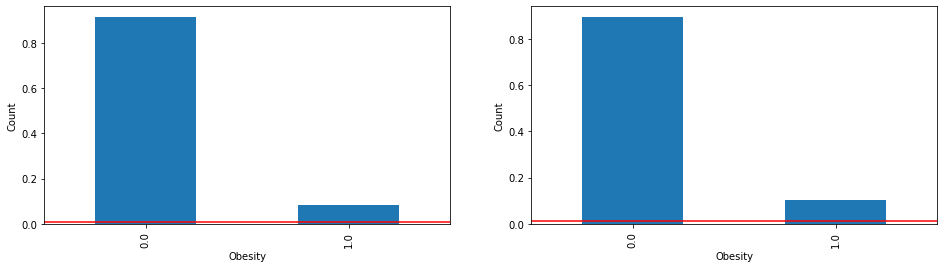

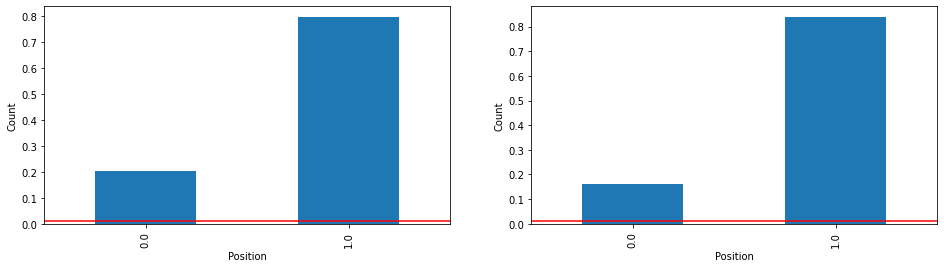

In [ ]:
for feature in discrete_features:
    compare_plot(train_df, test_df, feature)

Main observations:
- In some cases the distributions are a bit different. For example in train set there are more 0 values in the DifficultyInBreathing column comparing to the test set. Similar observation in the CardiovascularDisease feature.
- Have to convert the floats to integers here 
- Maybe have to impute the missing values in DaysFever with 0. We do not have any evidence, but it seems quite suspicious for me.
- Some binary variables are highly imbalanced, but we do not have outliers in other cases

In [ ]:
train_df[train_df['DaysFever']<1]

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
196,1043.0,F,79.0,0,1.0,39.0,0.0,1.0,0.0,2.7,4.55,2.27,302.0,93.0,0.03,213.0,1.04,NaN,NaN,62.6,NaN,45.0,7.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,158,MILD


This is maybe an anomaly, it cannot be 0, if the patient does not have fever, it should be a missing value. Or maybe they just recorded it in this case, but not in other cases... Anyway, very strange.

In [ ]:
## Replace missing value with a new label
def replace_cat_feature(dataset,features_nan):
    data=dataset.copy()
    data[features_nan]=data[features_nan].fillna('Missing')
    return data

dataset=replace_cat_feature(train_df,'DaysFever')

dataset['DaysFever'].isnull().sum()

0

<AxesSubplot:xlabel='DaysFever', ylabel='count'>

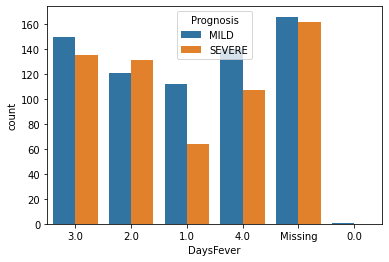

In [ ]:
sns.countplot(x='DaysFever', data=dataset, hue='Prognosis')

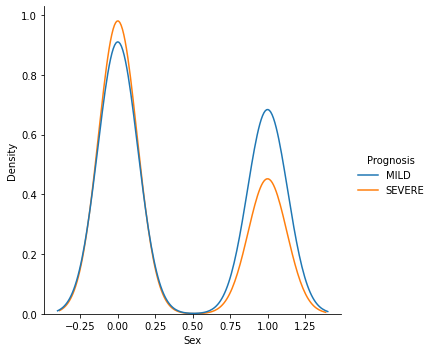

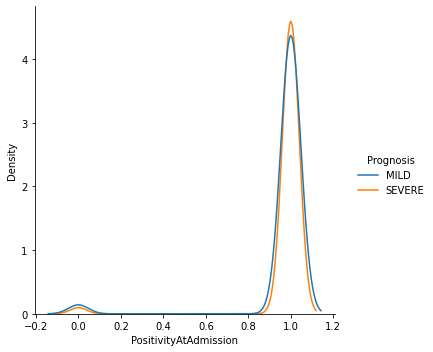

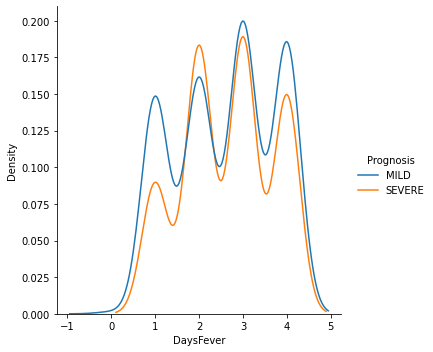

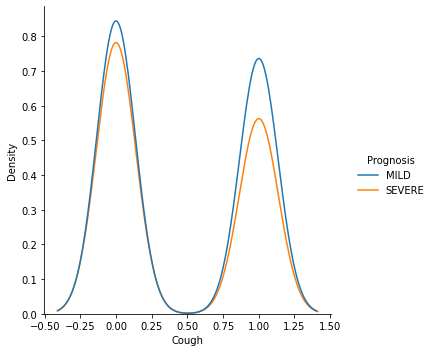

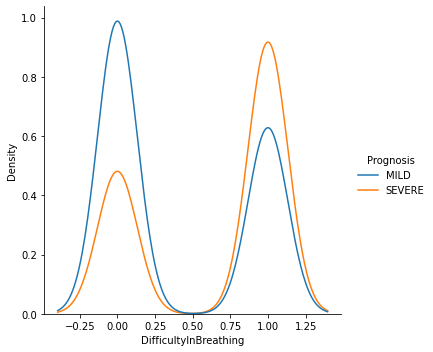

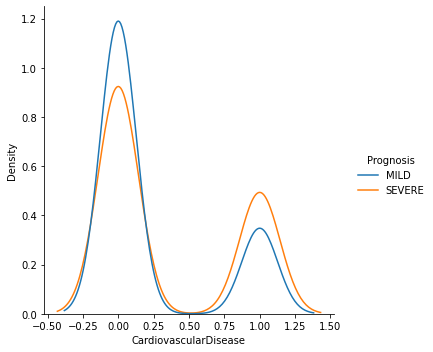

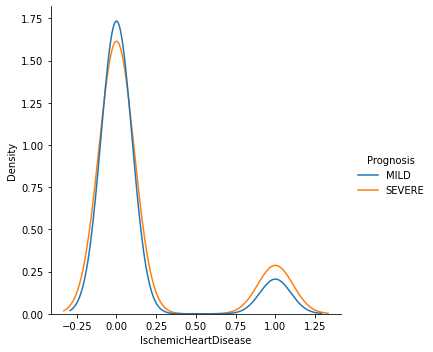

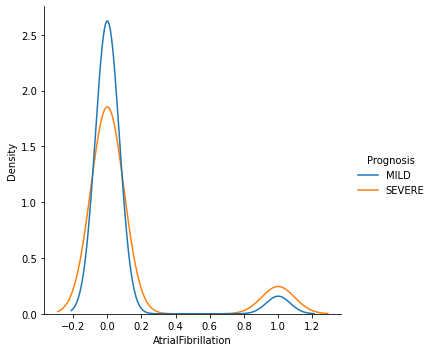

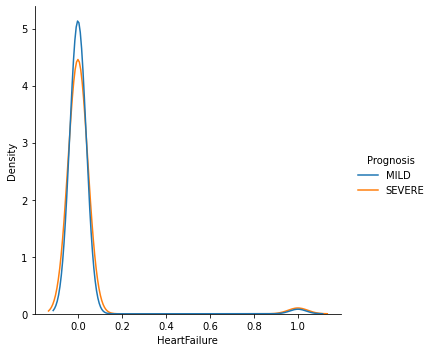

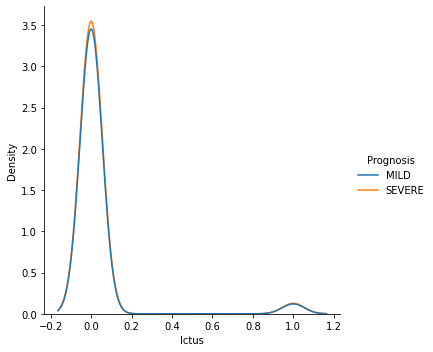

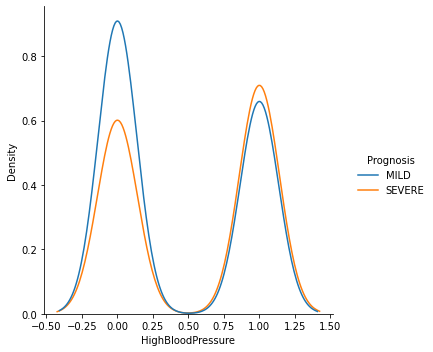

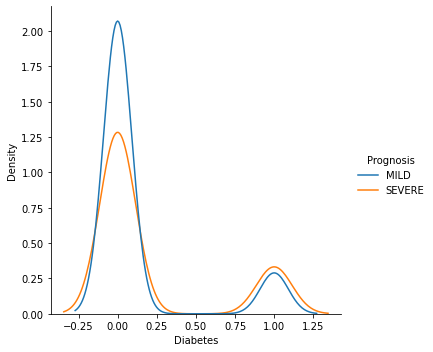

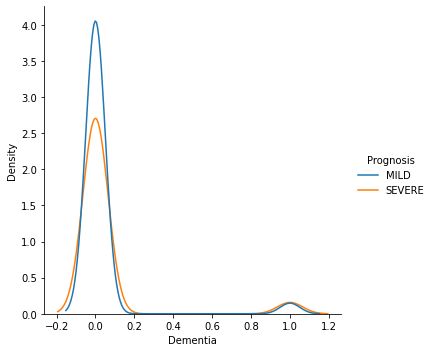

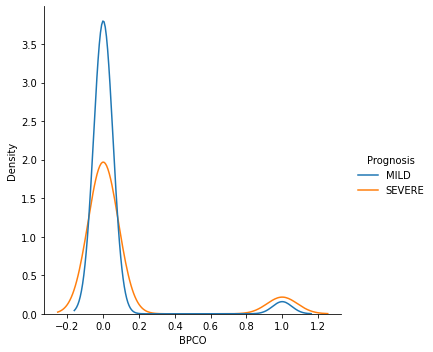

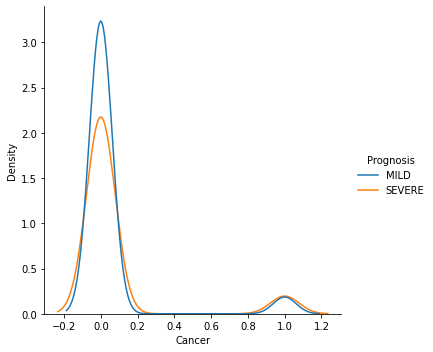

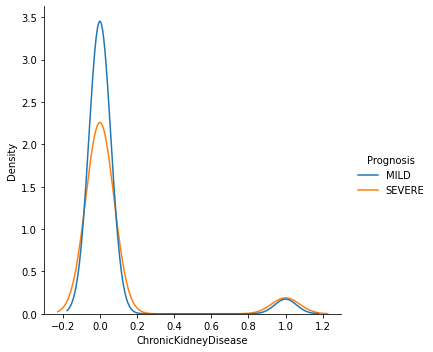

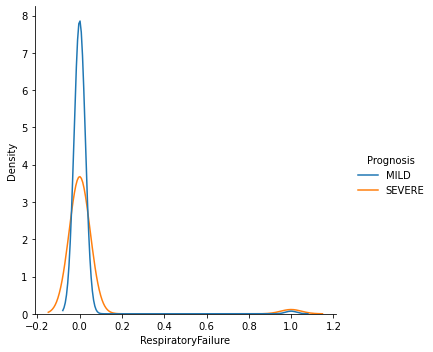

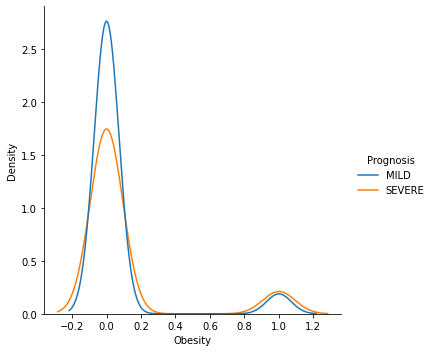

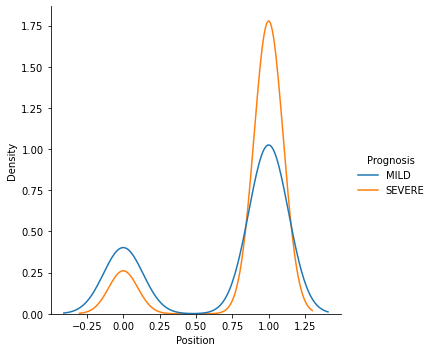

In [ ]:
for feature in discrete_features:
    sns.displot(data=train_df, x=feature, hue='Prognosis', kind='kde')
    plt.show()

In some cases we can see that the feature might have a relatively big predicting power (seems like a good separator).

# Feature Engineering

## Removing outliers

I don't know if it is really a good idea do it in the beginning of feature engineering, but will effect scaling and KNN imputation.

In [114]:
continuous_features.remove('Row_number')

In [61]:
continuous_features.remove('Image')

In [8]:
continuous_features.append('Prognosis')

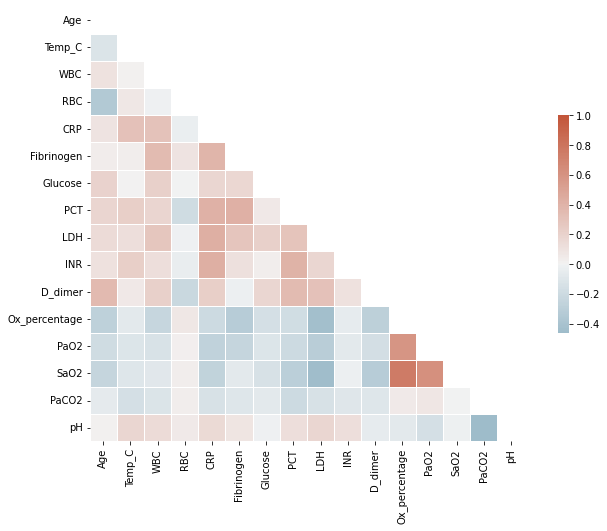

In [12]:
f, ax = plt.subplots(figsize=(12, 8))
mat = train_df[continuous_features].corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

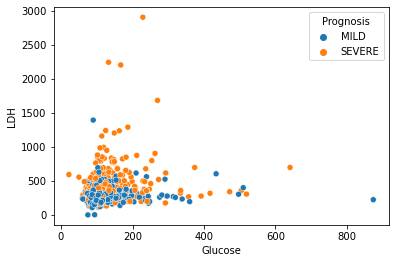

In [15]:
sns.scatterplot(x='Glucose', y='LDH', data=train_df, hue='Prognosis')
plt.show()

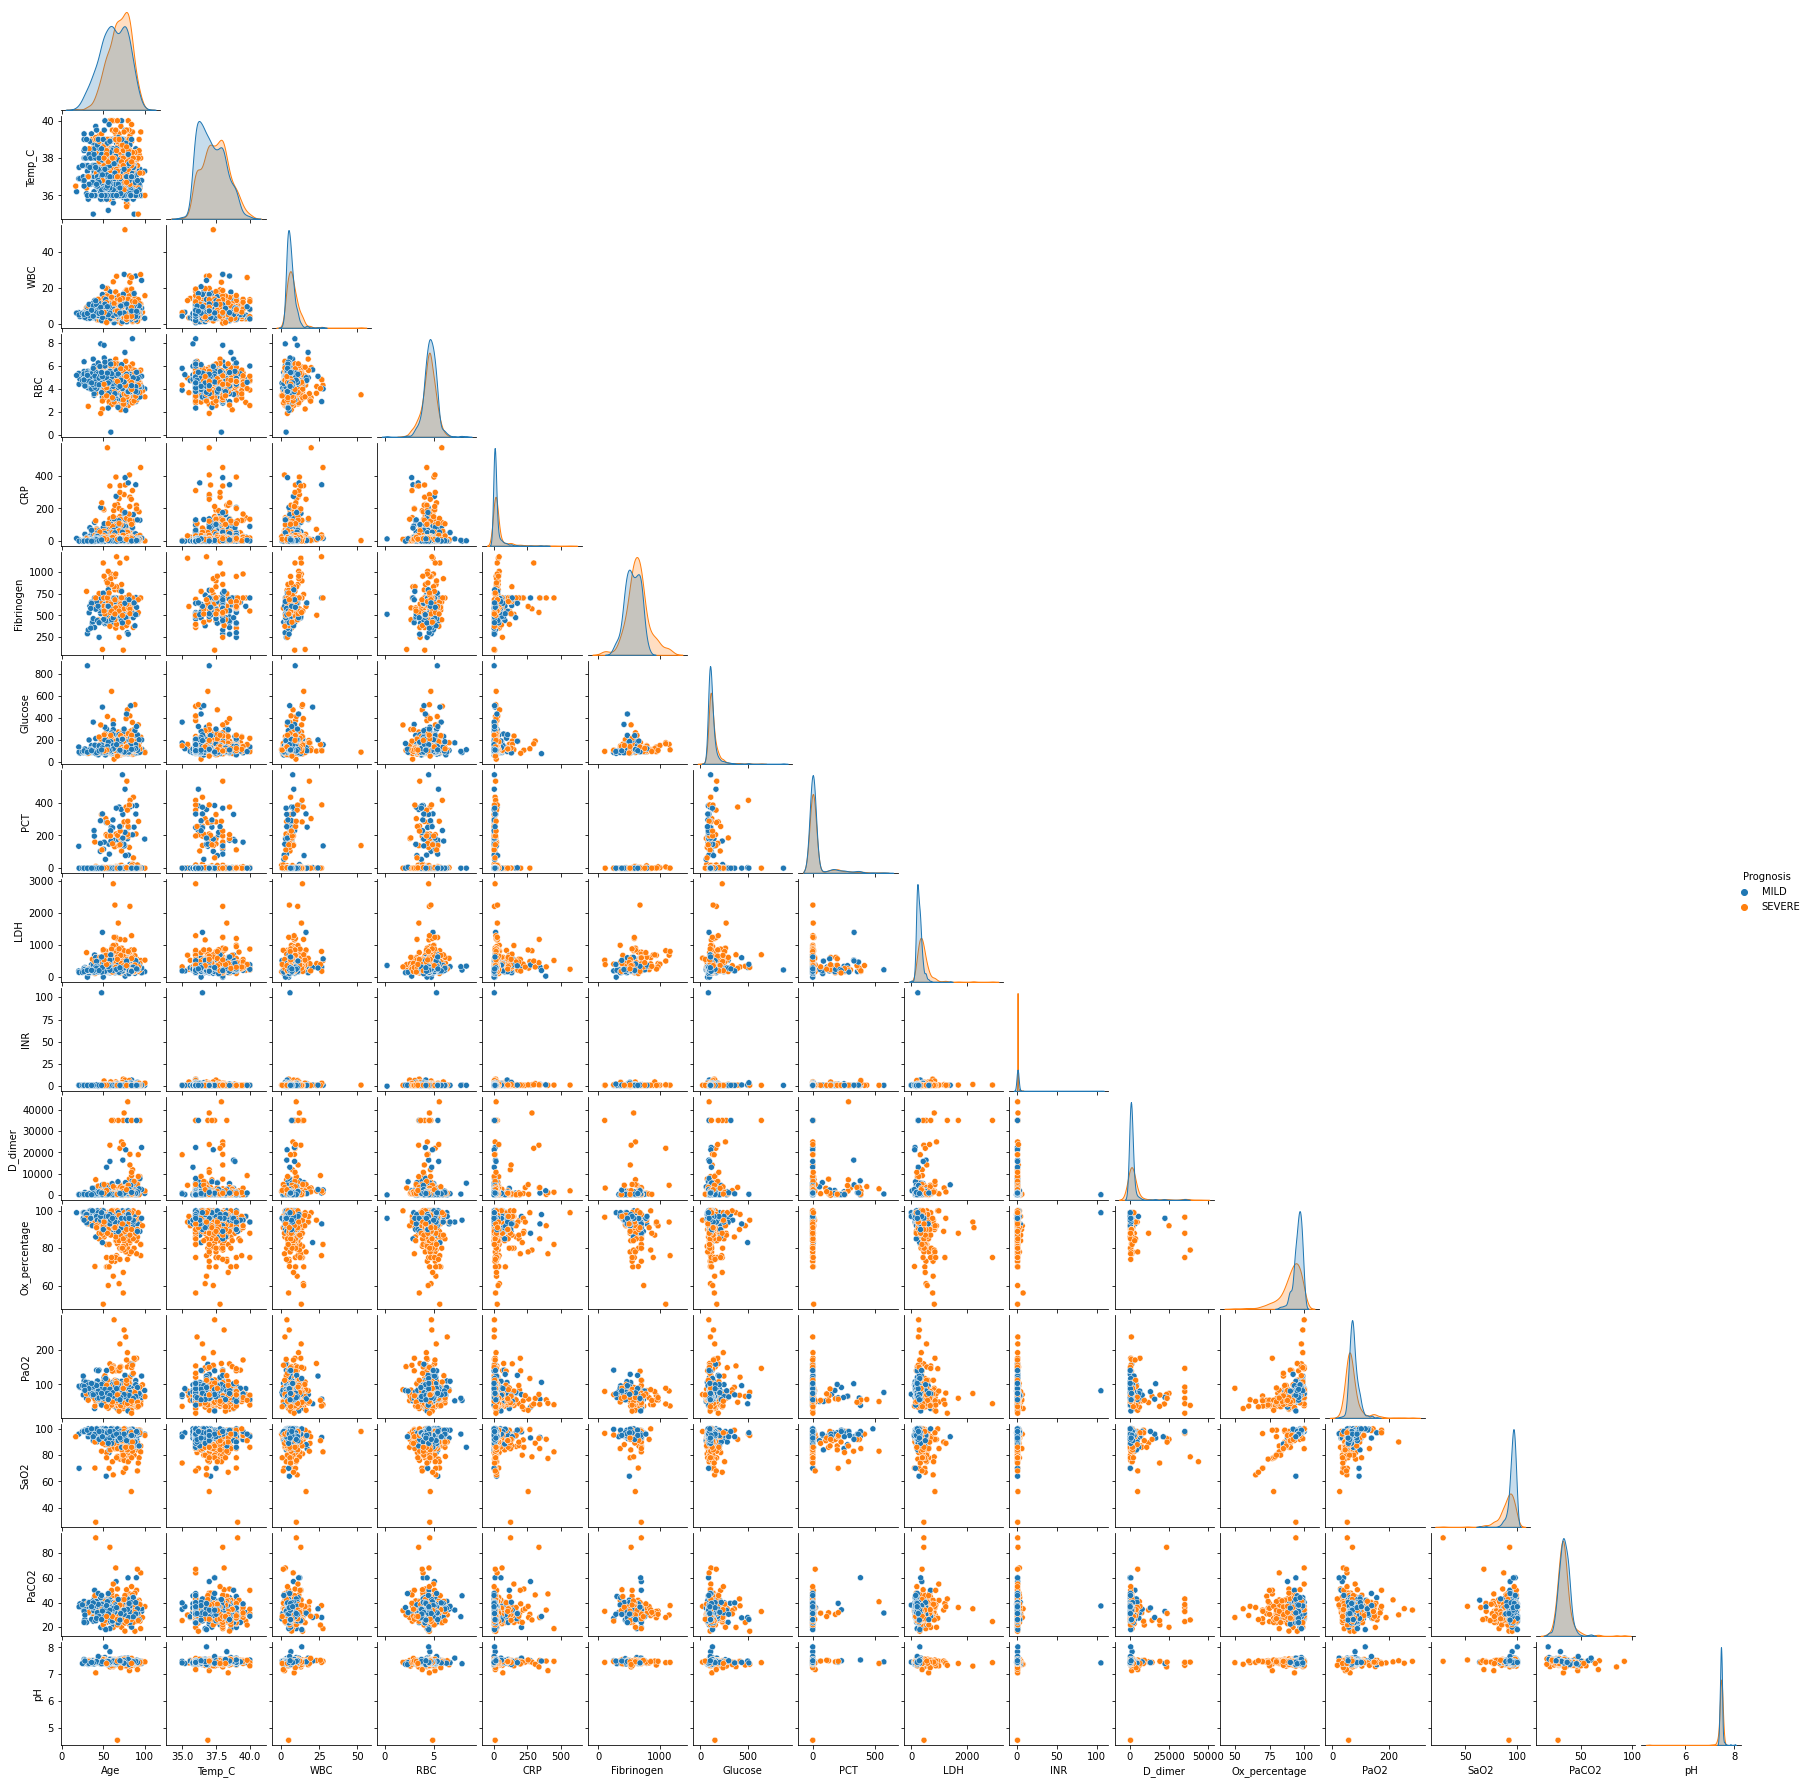

In [23]:
g = sns.pairplot(data=train_df[continuous_features], hue='Prognosis', corner=True)
g.fig.set_size_inches(25,25)

In [11]:
train_df.head()

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
0,228.0,D,35.913889,0,1.0,39.3,3.0,1.0,0.0,5.76,5.24,43.40,651.0,NaN,NaN,387.0,1.12,157.0,94.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,36,MILD
1,229.0,D,57.266667,0,1.0,37.0,3.0,0.0,0.0,11.48,5.71,64.00,700.0,NaN,NaN,338.0,1.23,601.0,94.0,75.0,96.9,37.0,7.42,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,37,MILD
2,96.0,A,39.000000,1,1.0,37.2,2.0,1.0,0.0,10.17,3.45,0.75,NaN,80.0,NaN,NaN,1.14,NaN,95.0,77.0,97.0,41.0,7.38,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20,MILD
3,112.0,A,44.000000,0,1.0,38.0,3.0,1.0,0.0,6.64,5.55,5.20,NaN,126.0,NaN,NaN,NaN,NaN,93.0,65.0,94.0,37.0,7.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66,SEVERE
4,97.0,A,76.000000,0,1.0,38.6,1.0,1.0,0.0,17.72,7.16,13.72,NaN,171.0,NaN,NaN,NaN,NaN,94.0,53.0,NaN,34.0,7.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,21,MILD


<AxesSubplot:xlabel='PaO2', ylabel='SaO2'>

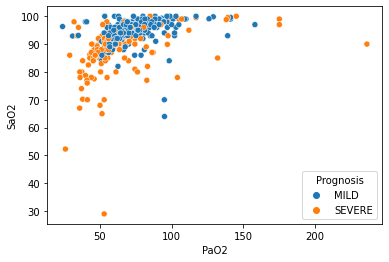

In [16]:
sns.scatterplot(data=train_df, x='PaO2', y='SaO2', hue='Prognosis')

In [12]:
train_df[train_df['Age']<20]

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
721,332.0,E,18.0,1,1.0,36.2,3.0,0.0,0.0,6.05,5.17,16.9,NaN,NaN,NaN,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,539,MILD
1138,1368.0,F,17.0,0,1.0,36.5,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,754,SEVERE


1138 observation an outlier, most of the 'young' patent are classified mild (intuitively too and based on the plots as well).

In [14]:
train_df[train_df['RBC']<1]

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
10,220.0,D,59.108333,0,1.0,37.9,2.0,1.0,0.0,3.36,0.25625,13.7,513.0,NaN,NaN,364.0,0.04375,140.0,96.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,27,MILD


Observation #10 can be considered as an outlier because of the same reasoning (it was obtained on the density plots but somehow didn't recognise this then).

<AxesSubplot:xlabel='SaO2', ylabel='Ox_percentage'>

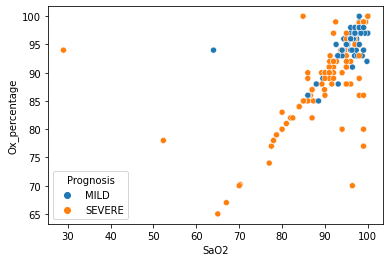

In [17]:
sns.scatterplot(data=train_df, x='SaO2', y='Ox_percentage', hue='Prognosis')

In [14]:
train_df[train_df['SaO2']<80].sort_values('SaO2')

,Row_number,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis
687,154.0,D,41.000000,0,1.0,39.1,3.0,1.0,0.0,10.03,4.61,124.30,700.0,NaN,NaN,451.0,1.24,NaN,94.0,53.0,29.0,92.3,7.48,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,99,SEVERE
694,173.0,D,83.663889,0,1.0,37.0,2.0,0.0,1.0,16.39,4.66,256.00,602.0,NaN,NaN,846.0,1.53,4958.0,78.0,26.0,52.3,37.0,7.53,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,286,SEVERE
469,153.0,D,53.544444,0,1.0,37.1,1.0,1.0,1.0,5.47,5.43,19.50,505.0,NaN,NaN,278.0,1.09,NaN,94.0,95.0,64.0,42.0,7.45,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,98,MILD
591,657.0,F,62.000000,0,1.0,36.8,1.0,1.0,1.0,10.60,5.23,18.73,NaN,149.0,NaN,783.0,NaN,NaN,65.0,51.5,65.0,36.1,7.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1415,SEVERE
837,756.0,F,74.000000,0,1.0,38.4,NaN,0.0,0.0,8.20,4.91,18.27,NaN,229.0,NaN,498.0,NaN,NaN,67.0,35.9,67.0,26.3,7.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1525,SEVERE
1067,1461.0,F,91.000000,1,1.0,36.0,1.0,0.0,1.0,1.52,3.84,9.58,NaN,166.0,19.70,387.0,1.10,5010.0,NaN,50.1,68.0,67.0,7.17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1078,SEVERE
810,642.0,F,57.000000,0,1.0,37.5,4.0,0.0,1.0,9.50,5.22,10.80,NaN,116.0,0.58,486.0,1.17,NaN,70.0,53.0,70.0,27.0,7.47,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1397,SEVERE
450,1113.0,C,76.279261,1,1.0,36.2,NaN,1.0,1.0,7.26,4.11,4.70,NaN,NaN,204.00,NaN,NaN,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402,SEVERE
1025,1375.0,F,21.000000,0,1.0,37.5,1.0,0.0,0.0,5.00,4.40,0.09,NaN,86.0,0.02,148.0,1.01,261.0,NaN,94.9,70.0,36.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,845,MILD
913,1610.0,F,77.000000,1,1.0,36.8,1.0,0.0,1.0,2.10,3.81,3.70,NaN,140.0,0.10,278.0,1.40,246.0,NaN,41.3,70.0,39.4,7.45,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,682,SEVERE


These 2 mild observations are quite 'dangerous' (in the sense of the analysis of course).<br>
#1025, #469. In addition #687 is an outlier too as it was obtained on the scatterplot above.

In [6]:
outliers = [10, 443, 869, 687, 910, 870, 1138, 1025, 469]
train_df = train_df.drop(train_df.index[outliers])

## One Hot Encoding

Scaling is more convinient if it is done before.

In [7]:
train_df = pd.get_dummies(train_df, prefix='Hospital', columns=['Hospital'], drop_first=True)
test_df = pd.get_dummies(test_df, prefix='Hospital', columns=['Hospital'], drop_first=True)

In [59]:
train_df.head()

,Row_number,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis,Hospital_B,Hospital_C,Hospital_D,Hospital_E,Hospital_F
0,228.0,35.913889,0,1.0,39.3,3.0,1.0,0.0,5.76,5.24,43.40,651.0,NaN,NaN,387.0,1.12,157.0,94.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,36,MILD,0,0,1,0,0
1,229.0,57.266667,0,1.0,37.0,3.0,0.0,0.0,11.48,5.71,64.00,700.0,NaN,NaN,338.0,1.23,601.0,94.0,75.0,96.9,37.0,7.42,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,37,MILD,0,0,1,0,0
2,96.0,39.000000,1,1.0,37.2,2.0,1.0,0.0,10.17,3.45,0.75,NaN,80.0,NaN,NaN,1.14,NaN,95.0,77.0,97.0,41.0,7.38,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20,MILD,0,0,0,0,0
3,112.0,44.000000,0,1.0,38.0,3.0,1.0,0.0,6.64,5.55,5.20,NaN,126.0,NaN,NaN,NaN,NaN,93.0,65.0,94.0,37.0,7.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66,SEVERE,0,0,0,0,0
4,97.0,76.000000,0,1.0,38.6,1.0,1.0,0.0,17.72,7.16,13.72,NaN,171.0,NaN,NaN,NaN,NaN,94.0,53.0,NaN,34.0,7.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,21,MILD,0,0,0,0,0


In [64]:
test_df.head()

,Row_number,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Hospital_B,Hospital_C,Hospital_D,Hospital_E,Hospital_F
0,82.0,72.000000,1,1.0,37.3,3.0,1.0,0.0,5.370000,4.58,3.96,NaN,98.0,NaN,NaN,0.99,NaN,93.0,63.0,93.0,34.0,7.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4,0,0,0,0,0
1,236.0,60.791667,1,1.0,37.0,2.0,1.0,0.0,6.370000,4.85,20.70,NaN,NaN,NaN,NaN,1.06,210.0,93.0,NaN,97.3,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,46,0,0,1,0,0
2,251.0,51.983333,0,1.0,38.5,4.0,1.0,0.0,12.130000,4.98,86.70,700.0,NaN,NaN,284.0,1.10,140.0,95.0,65.0,NaN,32.0,7.46,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,63,0,0,1,0,0
3,238.0,62.891667,0,1.0,NaN,NaN,0.0,1.0,0.509028,5.11,88.10,NaN,NaN,NaN,NaN,NaN,958.0,85.0,65.0,98.0,17.0,7.50,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,1.0,48,0,0,1,0,0
4,266.0,44.000000,0,0.0,37.7,4.0,0.0,0.0,9.180000,5.12,42.70,NaN,242.0,0.02,243.0,1.20,NaN,98.0,23.0,NaN,35.0,7.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,502,0,0,0,1,0


In [8]:
test_df['WBC'] = np.round(test_df['WBC'],2)

In [21]:
train_df[train_df['DaysFever']<1]

,Row_number,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Image,Prognosis,Hospital_B,Hospital_C,Hospital_D,Hospital_E,Hospital_F
196,1043.0,79.0,0,1.0,39.0,0.0,1.0,0.0,2.7,4.55,2.27,302.0,93.0,0.03,213.0,1.04,NaN,NaN,62.6,NaN,45.0,7.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,158,MILD,0,0,0,0,1


This is the only observation with zero value in the DaysFever column, I assume this is a data-error. I am going to delete the DaysFever value and impute with KNN later.

In [9]:
train_df.loc[train_df['DaysFever']<1, 'DaysFever'] = None

## Drop features

In [10]:
train_df.drop('Row_number', axis=1, inplace=True)
test_df.drop('Row_number', axis=1, inplace=True)
train_df.drop('Image', axis=1, inplace=True)
test_df.drop('Image', axis=1, inplace=True)

## Scaling

In [11]:
not_to_scale = [feature for feature in train_df.columns if len(train_df[feature].unique()) <= 5]
to_scale = [feature for feature in train_df.columns if len(train_df[feature].unique()) > 5]
len(to_scale) + len(not_to_scale) == train_df.shape[1]

True

In [13]:
scaler=StandardScaler()
scaler.fit_transform(train_df[to_scale])

array([[-1.9492127 ,  2.01610969, -0.34350635, ...,         nan,
                nan,         nan],
       [-0.55288717, -0.32644263,  1.31358558, ...,  0.66032211,
         0.62054798, -0.27700006],
       [-1.74740215, -0.12274243,  0.93407676, ...,  0.67780674,
         1.30122016, -0.61756008],
       ...,
       [ 0.27978569, -0.93754323, -0.27397802, ..., -0.02157846,
        -1.26831733,  0.40411999],
       [ 1.58764881, -1.14124344,  0.0446935 , ...,  0.85265304,
                nan,         nan],
       [-1.15886375,  1.20130888, -0.18706761, ...,         nan,
        -1.20025011,         nan]])

In [14]:
train_df = pd.concat([train_df[not_to_scale].reset_index(drop=True), 
                    pd.DataFrame(scaler.fit_transform(train_df[to_scale]), columns=to_scale)],
                    axis=1)

In [66]:
train_df.head()

,Sex,PositivityAtAdmission,Cough,DifficultyInBreathing,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Prognosis,Hospital_B,Hospital_C,Hospital_D,Hospital_E,Hospital_F,Age,Temp_C,DaysFever,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH
0,0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,MILD,0,0,1,0,0,-1.949213,2.016110,0.346295,-0.343506,0.957515,0.357984,0.301931,NaN,NaN,0.198087,-0.141310,-0.371168,0.187300,NaN,NaN,NaN,NaN
1,0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,MILD,0,0,1,0,0,-0.552887,-0.326443,0.346295,1.313586,1.638751,0.755557,0.607518,NaN,NaN,-0.044372,0.043540,-0.285202,0.187300,0.093411,0.660322,0.620548,-0.27700
2,1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MILD,0,0,0,0,0,-1.747402,-0.122742,-0.601041,0.934077,-1.636977,-0.465147,NaN,-0.855336,NaN,NaN,-0.107701,NaN,0.338594,0.175759,0.677807,1.301220,-0.61756
3,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SEVERE,0,0,0,0,0,-1.420436,0.692058,0.346295,-0.088569,1.406841,-0.379263,NaN,0.027812,NaN,NaN,NaN,NaN,0.036007,-0.318330,0.153268,0.620548,0.14870
4,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,MILD,0,0,0,0,0,0.672145,1.303159,-1.548376,3.121322,3.740434,-0.214830,NaN,0.891762,NaN,NaN,NaN,NaN,0.187300,-0.812419,NaN,0.110044,1.25552


In [15]:
not_to_scale.remove('Prognosis')

In [16]:
scaler=StandardScaler()
scaler.fit_transform(test_df[to_scale])

array([[ 0.42424749, -0.069081  , -0.44644533, ...,  0.04669044,
         0.20728664, -0.06051063],
       [-0.35840967, -0.36134674, -0.14995803, ...,  0.72819951,
                nan,         nan],
       [-0.97347927,  1.099982  ,  1.55780881, ...,         nan,
        -0.20545224, -0.06051063],
       ...,
       [ 0.1449349 ,  1.29482583, -0.55614563, ...,  0.3636714 ,
        -0.78328667,  0.8674785 ],
       [-0.41369029, -1.14072208, -0.48498868, ...,  0.52216189,
         0.92957967,  1.48613792],
       [-1.46111251,  1.39224775,  0.21472135, ...,  0.20518092,
                nan,         nan]])

In [17]:
test_df = pd.concat([test_df[not_to_scale].reset_index(drop=True), 
                    pd.DataFrame(scaler.fit_transform(test_df[to_scale]), columns=to_scale)],
                    axis=1)

In [18]:
test_df.head()

,Sex,PositivityAtAdmission,DaysFever,Cough,DifficultyInBreathing,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Hospital_B,Hospital_C,Hospital_D,Hospital_E,Hospital_F,Age,Temp_C,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH
0,1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.424247,-0.069081,-0.446445,-0.006289,-0.408552,NaN,-0.609980,NaN,NaN,-0.448909,NaN,0.146688,-0.343020,0.046690,0.207287,-0.060511
1,1,1.0,2.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0,0,1,0,0,-0.358410,-0.361347,-0.149958,0.421196,-0.140448,NaN,NaN,NaN,NaN,-0.217653,-0.289959,0.146688,NaN,0.728200,NaN,NaN
2,0,1.0,4.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0,0,1,0,0,-0.973479,1.099982,1.557809,0.627022,0.916592,0.76273,NaN,NaN,-0.344159,-0.085506,-0.305052,0.420248,-0.272301,NaN,-0.205452,-0.060511
3,0,1.0,NaN,0.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,1.0,0,0,1,0,0,-0.211771,NaN,-1.887374,0.832848,0.939014,NaN,NaN,NaN,NaN,NaN,-0.128686,-0.947551,-0.272301,0.839143,-3.300994,0.558149
4,0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,-1.530941,0.320607,0.683171,0.848681,0.211899,NaN,2.424766,-0.345664,-0.528704,0.244859,NaN,0.830588,-1.757407,NaN,0.413656,-0.524505


## Missing data imputation

In [19]:
train_df['Prognosis'] = train_df.Prognosis.map(dict(MILD=0, SEVERE=1))

In [20]:
train_col = train_df.columns
imputer = KNNImputer()
train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_col)

In [21]:
train_df['CardiovascularDisease'] = train_df['CardiovascularDisease'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['IschemicHeartDisease'] = train_df['IschemicHeartDisease'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['AtrialFibrillation'] = train_df['AtrialFibrillation'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['HeartFailure'] = train_df['HeartFailure'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['Ictus'] = train_df['Ictus'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['HighBloodPressure'] = train_df['HighBloodPressure'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['Diabetes'] = train_df['Diabetes'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['Dementia'] = train_df['Dementia'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['BPCO'] = train_df['BPCO'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['Cancer'] = train_df['Cancer'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['ChronicKidneyDisease'] = train_df['ChronicKidneyDisease'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['RespiratoryFailure'] = train_df['RespiratoryFailure'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['Obesity'] = train_df['Obesity'].apply(lambda x: 1.0 if x>0.5 else 0.0)
train_df['Position'] = train_df['Position'].apply(lambda x: 1.0 if x>0.5 else 0.0)

In [22]:
train_df['DifficultyInBreathing'] = train_df['DifficultyInBreathing'].apply(lambda x: 1.0 if x>0.5 else 0.0)

In [23]:
train_df['Cough'] = train_df['Cough'].apply(lambda x: 1.0 if x>0.5 else 0.0)

In [24]:
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 3.0 if x==2.6 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 3.0 if x==2.8 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 2.0 if x==2.2 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 2.0 if x==2.4 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 3.0 if x==3.2 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 2.0 if x==1.8 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 3.0 if x==3.4 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 2.0 if x==1.6 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 1.0 if x==1.4 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 4.0 if x==3.6 else x)
train_df['DaysFever'] = train_df['DaysFever'].apply(lambda x: 1.0 if x==1.2 else x)

In [25]:
train_df['PositivityAtAdmission'] = train_df['PositivityAtAdmission'].apply(lambda x: 1.0 if x==0.8 else x)

In [26]:
for feature in not_to_scale:
    train_df[feature] = train_df[feature].apply(int)

In [27]:
train_df['DaysFever'] = train_df['DaysFever'].apply(str)

In [28]:
train_df = pd.get_dummies(train_df, prefix='DaysFever', columns=['DaysFever'], drop_first=True)

In [30]:
test_col = test_df.columns
imputer_test = KNNImputer()
test_df = pd.DataFrame(imputer_test.fit_transform(test_df), columns=test_col)

In [31]:
test_df.head()

,Sex,PositivityAtAdmission,DaysFever,Cough,DifficultyInBreathing,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Hospital_B,Hospital_C,Hospital_D,Hospital_E,Hospital_F,Age,Temp_C,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH
0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.424247,-0.069081,-0.446445,-0.006289,-0.408552,-0.058437,-0.609980,0.719427,-0.505298,-0.448909,-0.180389,0.146688,-0.343020,0.046690,0.207287,-0.060511
1,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,1.0,0.0,0.0,-0.358410,-0.361347,-0.149958,0.421196,-0.140448,0.124822,0.140276,-0.345122,-0.454886,-0.217653,-0.289959,0.146688,0.164037,0.728200,0.161885,-0.307974
2,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,1.0,0.0,0.0,-0.973479,1.099982,1.557809,0.627022,0.916592,0.762730,-0.626840,-0.337888,-0.344159,-0.085506,-0.305052,0.420248,-0.272301,0.493634,-0.205452,-0.060511
3,0.0,1.0,2.6,0.0,1.0,1.0,0.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,1.0,0.0,0.0,1.0,0.0,0.0,-0.211771,-0.088565,-1.887374,0.832848,0.939014,-0.447337,-0.449813,-0.342667,0.029430,-0.211045,-0.128686,-0.947551,-0.272301,0.839143,-3.300994,0.558149
4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.530941,0.320607,0.683171,0.848681,0.211899,-0.075224,2.424766,-0.345664,-0.528704,0.244859,-0.196257,0.830588,-1.757407,0.509483,0.413656,-0.524505


In [48]:
test_df['CardiovascularDisease'] = test_df['CardiovascularDisease'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['PositivityAtAdmission'] = test_df['PositivityAtAdmission'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['IschemicHeartDisease'] = test_df['IschemicHeartDisease'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['AtrialFibrillation'] = test_df['AtrialFibrillation'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['HeartFailure'] = test_df['HeartFailure'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['Ictus'] = test_df['Ictus'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['HighBloodPressure'] = test_df['HighBloodPressure'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['Diabetes'] = test_df['Diabetes'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['Dementia'] = test_df['Dementia'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['BPCO'] = test_df['BPCO'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['Cancer'] = test_df['Cancer'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['ChronicKidneyDisease'] = test_df['ChronicKidneyDisease'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['RespiratoryFailure'] = test_df['RespiratoryFailure'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['Obesity'] = test_df['Obesity'].apply(lambda x: 1.0 if x>0.5 else 0.0)
test_df['Position'] = test_df['Position'].apply(lambda x: 1.0 if x>0.5 else 0.0)

In [50]:
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 3.0 if x==2.6 else x)
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 3.0 if x==2.8 else x)
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 2.0 if x==2.2 else x)
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 2.0 if x==2.4 else x)
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 3.0 if x==3.2 else x)
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 2.0 if x==1.8 else x)
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 3.0 if x==3.4 else x)
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 2.0 if x==1.6 else x)
test_df['DaysFever'] = test_df['DaysFever'].apply(lambda x: 1.0 if x==1.4 else x)

In [53]:
for feature in not_to_scale:
    test_df[feature] = test_df[feature].apply(int)

In [55]:
test_df['DaysFever'] = test_df['DaysFever'].apply(str)
test_df = pd.get_dummies(test_df, prefix='DaysFever', columns=['DaysFever'], drop_first=True)

In [57]:
train_df.to_csv('train_processed.csv', index=False)
test_df.to_csv('test_processed.csv', index=False)

# Applied ML methods

In [86]:
train_df = pd.read_csv('train_processed.csv')
train_df['Prognosis'] = train_df['Prognosis'].apply(int)
X_train = train_df.drop(['Prognosis'], axis=1)
y_train = train_df['Prognosis']

In [85]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='balanced_accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

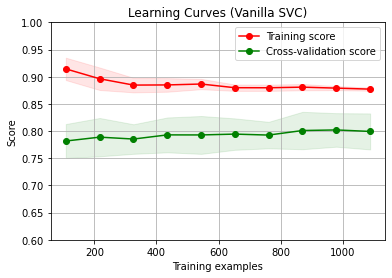

In [90]:
title = "Learning Curves (Vanilla SVC)"
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=RANDOM_STATE)
estimator = SVC(random_state=RANDOM_STATE)
plot_learning_curve(estimator, title, X_train, y_train, (0.6, 1.0), cv=cv)
plt.show()

In [92]:
1000 / len(train_df)

0.78125

Roughly 80-20 train-test split seems to be a good choice.

In [95]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

## Feature selection

In [98]:
def search_results_optuna(study):
    unnecessary = ['number', 'datetime_start', 'datetime_complete', 'duration', 'state']
    results = study.trials_dataframe()
    for col in unnecessary:
        results.drop([col], axis=1, inplace=True)
    results.sort_values(by='value', ascending=False, inplace=True)
    return results

In [100]:
def rf_feature_selection_objective(trial):
    model = RandomForestClassifier(
        min_samples_split = trial.suggest_float('min_samples_split', 2/X_t.shape[0], 0.01),
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
        min_samples_leaf = trial.suggest_float('min_samples_leaf', 1/X_t.shape[0], 0.01),
        class_weight = 'balanced_subsample',
        n_estimators = trial.suggest_int('n_estimators', 50, 180),
        max_depth = trial.suggest_categorical('max_depth', [3, 8, 12, None]),
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        random_state = RANDOM_STATE
        )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=5)
    roc_auc_mean = score.mean()
    return roc_auc_mean

rf_fs_study = optuna.create_study(
    direction="maximize"
)

rf_fs_study.optimize(rf_feature_selection_objective, n_trials=12)

[I 2022-04-22 22:57:20,886] A new study created in memory with name: no-name-98773a89-b057-4a76-b841-44bfb37916d5
[I 2022-04-22 22:57:21,986] Trial 0 finished with value: 0.7964581461793199 and parameters: {'min_samples_split': 0.0042770018006421, 'criterion': 'entropy', 'min_samples_leaf': 0.0031037064898029, 'n_estimators': 69, 'max_depth': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7964581461793199.
[I 2022-04-22 22:57:24,360] Trial 1 finished with value: 0.8051106958021851 and parameters: {'min_samples_split': 0.004311976045476348, 'criterion': 'entropy', 'min_samples_leaf': 0.006462586271304921, 'n_estimators': 177, 'max_depth': None, 'max_features': 'log2'}. Best is trial 1 with value: 0.8051106958021851.
[I 2022-04-22 22:57:25,123] Trial 2 finished with value: 0.8068070454266405 and parameters: {'min_samples_split': 0.004165562521874203, 'criterion': 'entropy', 'min_samples_leaf': 0.005388032737932914, 'n_estimators': 52, 'max_depth': 8, 'max_features': 'sqrt'}. 

In [102]:
search_results_optuna(rf_fs_study).head()

,value,params_criterion,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators
10,0.809425,gini,NaN,log2,0.009577,0.009763,112
11,0.809425,gini,NaN,log2,0.009574,0.009983,112
4,0.808366,entropy,12.0,sqrt,0.004089,0.007862,165
2,0.806807,entropy,8.0,sqrt,0.005388,0.004166,52
1,0.805111,entropy,NaN,log2,0.006463,0.004312,177


In [103]:
rf = RandomForestClassifier(
    min_samples_split = rf_fs_study.best_params['min_samples_split'],
    criterion = rf_fs_study.best_params['criterion'],
    min_samples_leaf = rf_fs_study.best_params['min_samples_leaf'],
    class_weight = 'balanced_subsample',
    n_estimators = rf_fs_study.best_params['n_estimators'],
    max_features = rf_fs_study.best_params['max_features'],
    max_depth = rf_fs_study.best_params['max_depth'],
    random_state = RANDOM_STATE
        )
rf.fit(X_t.values, y_t)

RandomForestClassifier(class_weight='balanced_subsample', max_features='log2',
                       min_samples_leaf=0.009576510910995675,
                       min_samples_split=0.009762986145133684, n_estimators=112,
                       random_state=1)

In [107]:
permutation_results = permutation_importance(
    rf, X_t.values, y_t, scoring='balanced_accuracy', random_state=RANDOM_STATE, n_jobs=-1, n_repeats=20
)

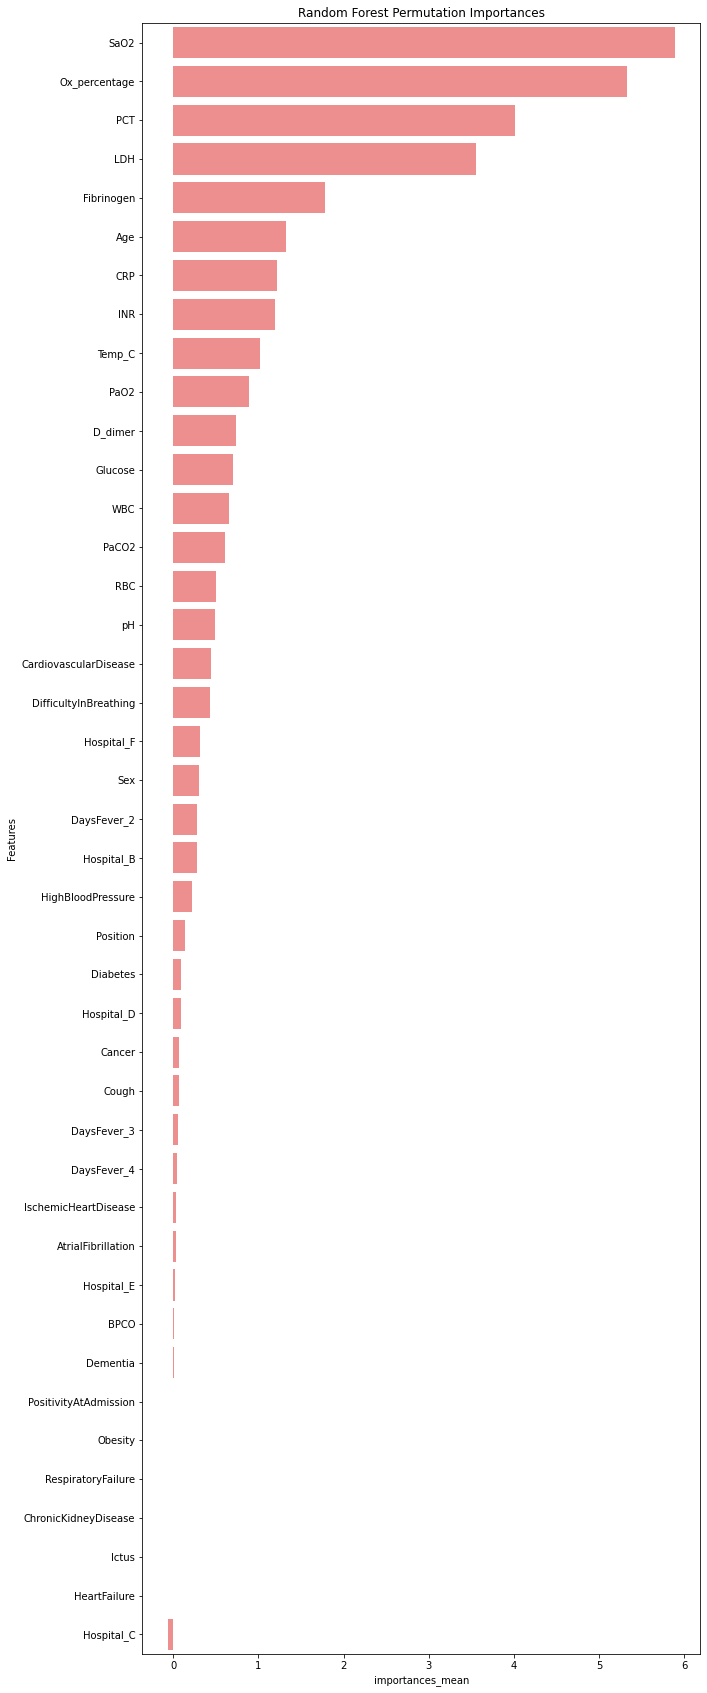

In [108]:
permutation_results_df = pd.DataFrame({'importances_mean': permutation_results.importances_mean*100, 'Features': X_t.columns})
plt.figure(figsize=(10,30))
sns.barplot(x='importances_mean', y='Features', data=permutation_results_df.sort_values(by ='importances_mean', ascending=False), color='red', alpha=0.5).set_title('Random Forest Permutation Importances')
plt.show()

In [109]:
selected_features_perm = permutation_results_df[permutation_results_df['importances_mean']>0]['Features'].to_list()

In [117]:
X_t = X_t[selected_features_perm]
X_val = X_val[selected_features_perm]
test_df = pd.read_csv('test_processed.csv')
test_df = test_df[selected_features_perm]

In [122]:
print(X_t.shape)
print(X_val.shape)
print(test_df.shape)

(1024, 35)
(256, 35)
(300, 35)


## SVM

### Linear SVC

In [132]:
def svc_objective(trial):
    model = LinearSVC(
        C = trial.suggest_float('C', 0.001, 100.0),
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2']),
        dual = False,
        class_weight = 'balanced',
        random_state = RANDOM_STATE
        )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=5)
    roc_auc_mean = score.mean()
    return roc_auc_mean

svc_study = optuna.create_study(
    direction="maximize"
)

svc_study.optimize(svc_objective, n_trials=40)

[I 2022-04-22 23:40:23,976] A new study created in memory with name: no-name-c5ed24aa-3e50-4c97-b4f5-137c50e37ac1
[I 2022-04-22 23:40:24,093] Trial 0 finished with value: 0.791757648912762 and parameters: {'C': 92.69485692228102, 'penalty': 'l1'}. Best is trial 0 with value: 0.791757648912762.
[I 2022-04-22 23:40:24,200] Trial 1 finished with value: 0.791757648912762 and parameters: {'C': 63.19203442337238, 'penalty': 'l1'}. Best is trial 0 with value: 0.791757648912762.
[I 2022-04-22 23:40:24,300] Trial 2 finished with value: 0.791757648912762 and parameters: {'C': 67.09132801434376, 'penalty': 'l1'}. Best is trial 0 with value: 0.791757648912762.
[I 2022-04-22 23:40:24,355] Trial 3 finished with value: 0.791757648912762 and parameters: {'C': 95.44919546542802, 'penalty': 'l2'}. Best is trial 0 with value: 0.791757648912762.
[I 2022-04-22 23:40:24,465] Trial 4 finished with value: 0.792658549813663 and parameters: {'C': 3.515016223901916, 'penalty': 'l1'}. Best is trial 4 with value: 

In [133]:
linearscv = LinearSVC(
    C = svc_study.best_params['C'],
    penalty = svc_study.best_params['penalty'],
    dual = False,
    class_weight = 'balanced',
    random_state = RANDOM_STATE
)
linearscv.fit(X_t.values, y_t)

LinearSVC(C=3.515016223901916, class_weight='balanced', dual=False,
          penalty='l1', random_state=1)

In [134]:
def evaluation(y_pred, y_true):
    return ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_val, cmap='Blues'), print(classification_report(y_pred=y_pred, y_true=y_val))

              precision    recall  f1-score   support

           0       0.75      0.78      0.77       128
           1       0.77      0.74      0.76       128

    accuracy                           0.76       256
   macro avg       0.76      0.76      0.76       256
weighted avg       0.76      0.76      0.76       256

Train balanced acc.:  0.818
Validation balanced acc.:  0.762


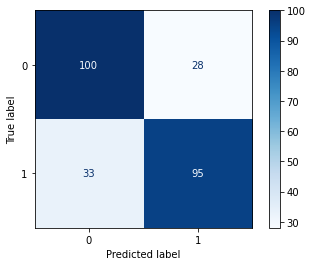

In [142]:
y_pred = linearscv.predict(X_val.values)
evaluation(y_pred, y_val)
X_train_pred_score = linearscv.predict(X_t.values)
print('Train balanced acc.: ', np.round(balanced_accuracy_score(y_t, X_train_pred_score),3))
print('Validation balanced acc.: ', np.round(balanced_accuracy_score(y_val, y_pred),3))

### SVC with linear kernel

In [156]:
def svc_objective(trial):
    model = SVC(
        C = trial.suggest_float('C', 0.001, 100.0),
        kernel = 'linear',
        gamma = trial.suggest_categorical('gamma', [0.5, 1, 2, 4, 8, 16]),
        random_state = RANDOM_STATE
        )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=5)
    roc_auc_mean = score.mean()
    return roc_auc_mean

svc_study = optuna.create_study(
    direction="maximize"
)

svc_study.optimize(svc_objective, n_trials=20)

[I 2022-04-23 00:12:57,871] A new study created in memory with name: no-name-8f1115b5-d02e-484c-ba86-f5668c2f9a8a
[I 2022-04-23 00:13:04,819] Trial 0 finished with value: 0.7988170430946684 and parameters: {'C': 75.71268066794055, 'gamma': 0.5}. Best is trial 0 with value: 0.7988170430946684.
[I 2022-04-23 00:13:10,374] Trial 1 finished with value: 0.7988170430946684 and parameters: {'C': 61.38828295837056, 'gamma': 2}. Best is trial 0 with value: 0.7988170430946684.
[I 2022-04-23 00:13:15,817] Trial 2 finished with value: 0.7988170430946684 and parameters: {'C': 70.80147117567421, 'gamma': 2}. Best is trial 0 with value: 0.7988170430946684.
[I 2022-04-23 00:13:22,061] Trial 3 finished with value: 0.7979161421937675 and parameters: {'C': 76.88008747399027, 'gamma': 4}. Best is trial 0 with value: 0.7988170430946684.
[I 2022-04-23 00:13:23,601] Trial 4 finished with value: 0.7988170430946684 and parameters: {'C': 16.478527964776713, 'gamma': 0.5}. Best is trial 0 with value: 0.798817043

In [157]:
search_results_optuna(svc_study).head(8)

,value,params_C,params_gamma
18,0.799881,33.579719,8.0
17,0.799881,39.425505,16.0
5,0.799881,25.076929,8.0
14,0.799881,29.216819,8.0
8,0.799881,36.275769,16.0
11,0.799881,36.190828,8.0
12,0.798980,38.168654,16.0
0,0.798817,75.712681,0.5


In [158]:
def svc_objective(trial):
    model = SVC(
        C = trial.suggest_float('C', 32.0, 42.0),
        kernel = 'linear',
        gamma = trial.suggest_float('gamma', 6, 20),
        random_state = RANDOM_STATE
        )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=5)
    roc_auc_mean = score.mean()
    return roc_auc_mean

svc_study = optuna.create_study(
    direction="maximize"
)

svc_study.optimize(svc_objective, n_trials=10)

[I 2022-04-23 00:16:16,038] A new study created in memory with name: no-name-8e965785-7af8-4cdc-8ebc-7ba16ddbb985
[I 2022-04-23 00:16:22,617] Trial 0 finished with value: 0.7989799719810016 and parameters: {'C': 41.57510617064089, 'gamma': 11.840261313132704}. Best is trial 0 with value: 0.7989799719810016.
[I 2022-04-23 00:16:26,117] Trial 1 finished with value: 0.7998808728819025 and parameters: {'C': 35.557911819838075, 'gamma': 9.337874659012787}. Best is trial 1 with value: 0.7998808728819025.
[I 2022-04-23 00:16:29,649] Trial 2 finished with value: 0.7989799719810016 and parameters: {'C': 39.22238963265347, 'gamma': 19.292474205161582}. Best is trial 1 with value: 0.7998808728819025.
[I 2022-04-23 00:16:33,070] Trial 3 finished with value: 0.7998808728819025 and parameters: {'C': 40.851010612152685, 'gamma': 10.666609210520054}. Best is trial 1 with value: 0.7998808728819025.
[I 2022-04-23 00:16:36,786] Trial 4 finished with value: 0.7989799719810016 and parameters: {'C': 37.9466

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       128
           1       0.79      0.73      0.76       128

    accuracy                           0.77       256
   macro avg       0.77      0.77      0.77       256
weighted avg       0.77      0.77      0.77       256

Train balanced acc.:  0.824
Validation balanced acc.:  0.766


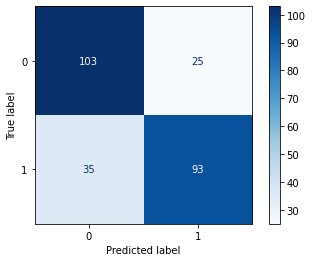

In [160]:
svc_linearkernel = SVC(
    C = svc_study.best_params['C'],
    kernel = 'linear',
    gamma = svc_study.best_params['gamma'],
    class_weight = 'balanced',
    random_state = RANDOM_STATE
)
svc_linearkernel.fit(X_t.values, y_t)
y_pred = svc_linearkernel.predict(X_val.values)
evaluation(y_pred, y_val)
X_train_pred_score = svc_linearkernel.predict(X_t.values)
print('Train balanced acc.: ', np.round(balanced_accuracy_score(y_t, X_train_pred_score),3))
print('Validation balanced acc.: ', np.round(balanced_accuracy_score(y_val, y_pred),3))

### SVC with polynomial kernel

In [164]:
def svc_objective(trial):
    model = SVC(
        C = trial.suggest_float('C', 0.001, 100.0),
        kernel = 'poly',
        degree = trial.suggest_int('degree', 2, 4),
        gamma = trial.suggest_categorical('gamma', [0.5, 1, 2, 4, 8, 16]),
        random_state = RANDOM_STATE
        )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=5)
    roc_auc_mean = score.mean()
    return roc_auc_mean

svc_study = optuna.create_study(
    direction="maximize"
)

svc_study.optimize(svc_objective, n_trials=25)

[I 2022-04-23 00:20:51,247] A new study created in memory with name: no-name-d7c0ad81-aaec-4268-951b-eacf76678d14
[I 2022-04-23 00:20:51,711] Trial 0 finished with value: 0.7645618354652328 and parameters: {'C': 92.00036186920178, 'degree': 2, 'gamma': 2}. Best is trial 0 with value: 0.7645618354652328.
[I 2022-04-23 00:20:51,943] Trial 1 finished with value: 0.7862019682198131 and parameters: {'C': 82.61185643073952, 'degree': 3, 'gamma': 1}. Best is trial 1 with value: 0.7862019682198131.
[I 2022-04-23 00:20:52,181] Trial 2 finished with value: 0.7862019682198131 and parameters: {'C': 0.5454181721668806, 'degree': 3, 'gamma': 16}. Best is trial 1 with value: 0.7862019682198131.
[I 2022-04-23 00:20:52,503] Trial 3 finished with value: 0.7862019682198131 and parameters: {'C': 46.86012844593999, 'degree': 3, 'gamma': 4}. Best is trial 1 with value: 0.7862019682198131.
[I 2022-04-23 00:20:52,969] Trial 4 finished with value: 0.7645618354652328 and parameters: {'C': 64.69722902690795, 'de

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       128
           1       0.76      0.68      0.72       128

    accuracy                           0.73       256
   macro avg       0.73      0.73      0.73       256
weighted avg       0.73      0.73      0.73       256

Train balanced acc.:  1.0
Validation balanced acc.:  0.73


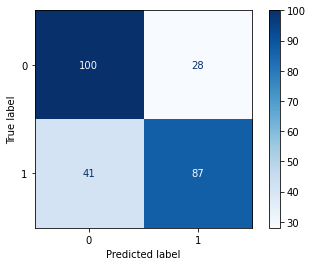

In [174]:
svc_polykernel = SVC(
    C = svc_study.best_params['C'],
    kernel = 'poly',
    gamma = svc_study.best_params['gamma'],
    degree = svc_study.best_params['degree'],
    class_weight = 'balanced',
    random_state = RANDOM_STATE
)
svc_polykernel.fit(X_t.values, y_t)
y_pred = svc_polykernel.predict(X_val.values)
evaluation(y_pred, y_val)
X_train_pred_score = svc_polykernel.predict(X_t.values)
print('Train balanced acc.: ', np.round(balanced_accuracy_score(y_t, X_train_pred_score),3))
print('Validation balanced acc.: ', np.round(balanced_accuracy_score(y_val, y_pred),3))

Highly overfitting. Try to tune it manually (won't include all experiments).

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       128
           1       0.79      0.73      0.76       128

    accuracy                           0.77       256
   macro avg       0.77      0.77      0.77       256
weighted avg       0.77      0.77      0.77       256

Train balanced acc.:  0.881
Validation balanced acc.:  0.766


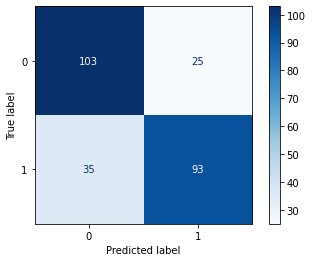

In [194]:
svc_polykernel = SVC(
    C = 0.01,
    kernel = 'poly',
    gamma = 0.8,
    degree = 2,
    class_weight = 'balanced',
    random_state = RANDOM_STATE
)
svc_polykernel.fit(X_t.values, y_t)
y_pred = svc_polykernel.predict(X_val.values)
evaluation(y_pred, y_val)
X_train_pred_score = svc_polykernel.predict(X_t.values)
print('Train balanced acc.: ', np.round(balanced_accuracy_score(y_t, X_train_pred_score),3))
print('Validation balanced acc.: ', np.round(balanced_accuracy_score(y_val, y_pred),3))

I cannot outperform the linear kernel approach with this setup.

### SVC with radial kernel

In [196]:
def svc_objective(trial):
    model = SVC(
        C = trial.suggest_float('C', 0.001, 100.0),
        kernel = 'rbf',
        gamma = trial.suggest_float('gamma', 0.5, 8.0),
        random_state = RANDOM_STATE
        )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=5)
    roc_auc_mean = score.mean()
    return roc_auc_mean

svc_study = optuna.create_study(
    direction="maximize"
)

svc_study.optimize(svc_objective, n_trials=30)

[I 2022-04-23 00:28:51,938] A new study created in memory with name: no-name-e8db6724-d47e-4ff8-adc0-8eb12dc7fd6c
[I 2022-04-23 00:28:52,360] Trial 0 finished with value: 0.5044296870652395 and parameters: {'C': 48.00256778059795, 'gamma': 1.3305127497867524}. Best is trial 0 with value: 0.5044296870652395.
[I 2022-04-23 00:28:52,766] Trial 1 finished with value: 0.5 and parameters: {'C': 38.9851963648105, 'gamma': 2.1943928281439677}. Best is trial 0 with value: 0.5044296870652395.
[I 2022-04-23 00:28:53,202] Trial 2 finished with value: 0.5 and parameters: {'C': 39.16029308054802, 'gamma': 7.666476880870023}. Best is trial 0 with value: 0.5044296870652395.
[I 2022-04-23 00:28:53,646] Trial 3 finished with value: 0.5 and parameters: {'C': 74.1580854309711, 'gamma': 2.75907127410052}. Best is trial 0 with value: 0.5044296870652395.
[I 2022-04-23 00:28:54,073] Trial 4 finished with value: 0.5 and parameters: {'C': 93.28730260383941, 'gamma': 4.886667268039709}. Best is trial 0 with valu

In [198]:
search_results_optuna(svc_study)

,value,params_C,params_gamma
15,0.761217,19.384170,0.523049
10,0.761217,2.392242,0.504662
25,0.761217,17.354320,0.507567
11,0.761217,5.065745,0.507208
12,0.758725,1.176226,0.587678
13,0.757812,2.526259,0.629617
22,0.534861,9.107719,0.951502
27,0.512093,18.494137,1.115859
29,0.506580,48.110550,1.264617
0,0.504430,48.002568,1.330513


In [199]:
def svc_objective(trial):
    model = SVC(
        C = trial.suggest_float('C', 1.0, 30.0),
        kernel = 'rbf',
        gamma = trial.suggest_float('gamma', 0.5, 2.5),
        class_weight = 'balanced',
        random_state = RANDOM_STATE
        )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=5)
    roc_auc_mean = score.mean()
    return roc_auc_mean

svc_study = optuna.create_study(
    direction="maximize"
)

svc_study.optimize(svc_objective, n_trials=30)

[I 2022-04-23 00:30:56,602] A new study created in memory with name: no-name-eda40a0f-ea9d-4fe2-9b67-f5dd7a89bdc6
[I 2022-04-23 00:30:57,028] Trial 0 finished with value: 0.5 and parameters: {'C': 20.242389704384628, 'gamma': 1.9074931169600133}. Best is trial 0 with value: 0.5.
[I 2022-04-23 00:30:57,419] Trial 1 finished with value: 0.5464363005028756 and parameters: {'C': 23.58381487342907, 'gamma': 0.9148823257152776}. Best is trial 1 with value: 0.5464363005028756.
[I 2022-04-23 00:30:57,826] Trial 2 finished with value: 0.5237972124983107 and parameters: {'C': 27.464887526004137, 'gamma': 0.9935819638465939}. Best is trial 1 with value: 0.5464363005028756.
[I 2022-04-23 00:30:58,248] Trial 3 finished with value: 0.5055049558824438 and parameters: {'C': 22.311254999552663, 'gamma': 1.3198309769626437}. Best is trial 1 with value: 0.5464363005028756.
[I 2022-04-23 00:30:58,638] Trial 4 finished with value: 0.537337319548198 and parameters: {'C': 4.090349212883467, 'gamma': 0.943046

In [204]:
search_results_optuna(svc_study).head(1)

,value,params_C,params_gamma
21,0.769,17.222495,0.734632


              precision    recall  f1-score   support

           0       0.82      0.77      0.79       128
           1       0.78      0.84      0.81       128

    accuracy                           0.80       256
   macro avg       0.80      0.80      0.80       256
weighted avg       0.80      0.80      0.80       256

Train balanced acc.:  0.827
Validation balanced acc.:  0.801


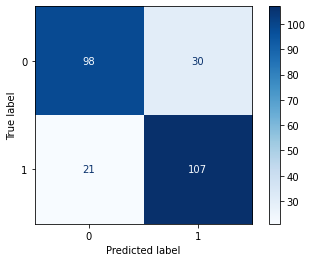

In [223]:
svc_rbfkernel = SVC(
    C = 0.3,
    kernel = 'rbf',
    gamma = 0.1,
    class_weight = 'balanced',
    random_state = RANDOM_STATE
)
svc_rbfkernel.fit(X_t.values, y_t)
y_pred = svc_rbfkernel.predict(X_val.values)
evaluation(y_pred, y_val)
X_train_pred_score = svc_rbfkernel.predict(X_t.values)
print('Train balanced acc.: ', np.round(balanced_accuracy_score(y_t, X_train_pred_score),3))
print('Validation balanced acc.: ', np.round(balanced_accuracy_score(y_val, y_pred),3))

I tuned again manually. Maybe I should have given smaller ranges in the objective... Anyway it seems like a quite stable result and hopefully robust enough on the test set as well.

# Submission

In [229]:
prediction = svc_rbfkernel.predict(test_df.values)
np.savetxt('dm_competition4_Berndt_Mihaly_submission1.txt', prediction, fmt="%d", comments='')

# Encode the submission

In [7]:
submission = pd.read_table('dm_competition4_Berndt_Mihaly_submission1.txt')

In [11]:
submission

,fejlec
0,0
1,0
2,0
3,1
4,0
...,...
295,0
296,1
297,0
298,0


In [18]:
submission = submission.replace({0: 'MILD', 1: 'SEVERE'})

In [20]:
submission

,fejlec
0,MILD
1,MILD
2,MILD
3,SEVERE
4,MILD
...,...
295,MILD
296,SEVERE
297,MILD
298,MILD


In [25]:
np.savetxt('dm_competition4_Berndt_Mihaly_submission2.txt', submission.values, fmt="%s", comments='')